# PREFERRED ACTIVITIES VISUALISATION

## 1. DATA & SETTINGS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pickle
from importlib import reload
import seaborn as sns

from collections import defaultdict
from itertools import chain 

import time
import joblib

import datetime as dt
from datetime import datetime, timedelta

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Importing
sample_6_we = pd.read_csv('data/2023_05_08_prefered_activity_we_6_full.csv')
sample_6_wd = pd.read_csv('data/2023_05_08_prefered_activity_wd_6_full.csv')

sample_24_we = pd.read_csv('data/2023_05_08_prefered_activity_we_24_full.csv')
sample_24_wd = pd.read_csv('data/2023_05_08_prefered_activity_wd_24_full.csv')

sample_144_we = pd.read_csv('data/2023_05_08_prefered_activity_we_144_full.csv')
sample_144_wd = pd.read_csv('data/2023_05_08_prefered_activity_wd_144_full.csv')

original_6_we = pd.read_csv('data/original_all_we_6.csv')
original_6_wd = pd.read_csv('data/original_all_wd_6.csv')

original_24_we = pd.read_csv('data/original_all_we_24.csv')
original_24_wd = pd.read_csv('data/original_all_wd_24.csv')

original_144_we = pd.read_csv('data/original_all_we_144.csv')
original_144_wd = pd.read_csv('data/original_all_wd_144.csv')

## 2. FUNCTIONS

In [4]:
def change_activities(df):
    """
    Replace activity values with corresponding labels and remove unnecessary columns.

    Args:
        df (DataFrame): Input DataFrame containing activity data.

    Returns:
        DataFrame: Modified DataFrame with activity labels and unnecessary columns removed.
    """

    # Define the activity labels to be displayed in the legend
    activity_labels = {
        0: "Home",
        2: "Work",
        3: "Education",
        4: "Shopping",
        5: "Use of services",
        6: "Business",
        7: "Ride",
        8: "Leisure",
        9: "Accompanying path children",
        10: "Accompanying path",
        11: "Return home",
        12: "Other"
    }

    # Replace the values in the "activity" column with the corresponding labels
    df['activity'] = df['activity_type'].replace(activity_labels)

    # Remove the 'Unnamed: 0' column
    df = df.drop('Unnamed: 0', axis=1)

    return df

In [5]:
def activity_colors(list_act=None, palette='gist_earth'):
    """
    Match each activity from the list to a color from the input palette.

    Args:
        list_act (list): List of activities to be matched with colors. Default is None.
        palette (str): Name of the color palette to be used. Default is 'gist_earth'.

    Returns:
        dict: A dictionary mapping activities to their corresponding colors.
    """

    if list_act is None:
        list_act = ["home", "work", "education", "shopping", "errands_services",
                    "business_trip", "leisure", "escort"]

    colors = {a: c for a, c in zip(list_act, sns.color_palette(palette, len(list_act)).as_hex())}

    if 'home' in colors.keys():
        colors['dawn'] = colors['home']
        colors['dusk'] = colors['home']

    return colors

def discretize_sched(schedule, block_size=0.5):
    """
    Discretize a schedule by dividing it into time slots of the specified block size.

    Args:
        schedule (DataFrame): Schedule data containing start time, duration, and activity labels.
        block_size (float): Size of each time slot in hours. Default is 0.5.

    Returns:
        dict: A dictionary mapping time slots to corresponding activity labels.
    """

    d_sched = {}
    time_slots = range(int(24 / block_size))
    sched = schedule.copy()

    mask = (sched.duration >= block_size)
    sched['d_start'] = sched.start_time.apply(lambda x: int(x / block_size))

    stimes = {t: a for t, a in zip(sched[mask].d_start.values, sched[mask].act_label.values)}
    current_act = 'home'

    for n in time_slots:
        if n in stimes.keys():
            current_act = stimes[n]
        d_sched[n] = current_act

    return d_sched

In [6]:
def proportions(list_act, sample):
    """
    Calculate the proportions of activities for each time slot in the given sample.

    Args:
        list_act (list): List of activities to include in the calculation.
        sample (DataFrame): Sample data containing slot, activity, and count information.

    Returns:
        DataFrame: A DataFrame with time slots as the index and activity proportions as columns.
    """

    # Count the occurrences of each (slot, activity) pair
    count_df = sample.groupby(['slot', 'activity']).size().reset_index(name='count')

    # Calculate the total count for each slot
    sum_df = count_df.groupby('slot')['count'].sum().reset_index(name='total')

    # Merge the two dataframes to obtain the proportions
    merged_df = pd.merge(count_df, sum_df, on='slot')
    merged_df['proportion'] = merged_df['count'] / merged_df['total']

    # Pivot the data to get the "disc_grouped" dataframe
    disc_grouped = merged_df.pivot(index='slot', columns='activity', values='proportion').reset_index()

    # Fill missing values with 0
    disc_grouped = disc_grouped.fillna(0)

    # Reorder columns according to the specified list of activities
    disc_grouped = disc_grouped[list_act]

    return disc_grouped

In [7]:
def plot_distribution(sample, list_act, emp=None):
    """
    Plot the distribution of activity proportions over time slots for the given sample.

    Args:
        sample (DataFrame): Sample data containing slot, activity, and count information.
        list_act (list): List of activities to include in the plot.
        emp (int, optional): Employee type (1: full-time worker, 2: part-time worker, 3: student, 4: unemployed).
            If specified, the plot will be generated only for the specified employee type. Default is None.

    Returns:
        None
    """

    if emp is not None:
        sample = sample[sample['emp'] == emp]
        if emp == 1:
            t = 'full-time worker'
        elif emp == 2:
            t = 'part-time worker'
        elif emp == 3:
            t = 'student'
        elif emp == 4:
            t = 'unemployed'

        title = ' for ' + t
    else:
        sample = sample
        title = ''

    fig, axs = plt.subplots(figsize=[12, 6])
    axs.set_facecolor('gainsboro')

    disc_grouped = proportions(list_act, sample)

    # Choosing colors
    colors = activity_colors(list_act=list_act, palette="colorblind")
    colors['Home'] = 'gainsboro'

    disc_grouped.drop('Home', axis=1).plot.bar(stacked=True, color=colors, edgecolor='white', width=1, ax=axs, legend=False, rot=1)

    patch = mpatches.Patch(color='gainsboro', label='Home')
    other_patches = [mpatches.Patch(color=f'{colors[a]}', label=f'{a}') for a in sorted(list_act)]

    plt.legend(handles=other_patches, loc='upper right', fontsize=16)
    axs.set_ylabel("Proportion (-)", fontsize=16)
    axs.set_xlabel("Time (h)", fontsize=16)

    num_bars = disc_grouped.shape[0]
    x_ticks = np.arange(0, num_bars+1, num_bars//24)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels(range(0, 25))

    #axs.set_title("Distribution (generation)" + title, fontsize=16)

    plt.setp(axs, ylim=[0, 1])

    plt.xticks(size=16)
    plt.yticks(size=16)

    return plt.show()

In [8]:
def plot_differences(sample, original, list_act, activity, y_max=0.5, y_ticks=0.5, emp=None):
    """
    Plot the differences in activity proportions for a specific activity between the sample and original data.

    Args:
        sample (DataFrame): Sample data containing slot, activity, and count information.
        original (DataFrame): Original data containing slot, activity, and count information.
        list_act (list): List of activities to include in the plot.
        activity (str): Activity for which the differences will be plotted.
        y_max (float, optional): Maximum value for the y-axis. Default is 0.5.
        y_ticks (float, optional): Tick interval for the y-axis. Default is 0.5.
        emp (int, optional): Employee type (1: full-time worker, 2: part-time worker, 3: student, 4: unemployed).
            If specified, the plot will be generated only for the specified employee type. Default is None.

    Returns:
        None
    """

    if emp is not None:
        sample = sample[sample['emp'] == emp]
        original = original[original['emp'] == emp]
        if emp == 1:
            t = 'full-time worker'
        elif emp == 2:
            t = 'part-time worker'
        elif emp == 3:
            t = 'student'
        elif emp == 4:
            t = 'unemployed'

        title = ' for ' + t
    else:
        sample = sample
        title = ''

    fig, axs = plt.subplots(figsize=[12, 6])

    sample_proportions = proportions(list_act, sample)
    original_proportions = proportions(list_act, original)

    difference = (sample_proportions[activity] - original_proportions[activity]) * 100

    # Choosing colors
    colors = activity_colors(list_act=list_act, palette="colorblind")
    colors['Home'] = 'gainsboro'

    difference.plot.bar(stacked=True, color=colors[activity], edgecolor='white', width=1, ax=axs, legend=False, rot=1)

    patch = mpatches.Patch(color=colors[activity], label=activity)

    plt.legend(handles=[patch], loc='upper right', fontsize=16)
    axs.set_ylabel("Difference (%)", fontsize=16)
    axs.set_xlabel("Time (h)", fontsize=16)

    num_bars = difference.shape[0]
    x_ticks = np.arange(0, num_bars+1, num_bars//24)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels(range(0, 25))

    #axs.set_title("Difference (%)" + title, fontsize=14)
    axs.grid(axis='y', linestyle='-', linewidth=0.8, which='major')
    axs.axhline(0, color='black', linewidth=1.5)

    axs.set_ylim([-y_max, y_max])
    axs.set_yticks(np.arange(-y_max, y_max+0.01, y_ticks))

    plt.xticks(size=16)
    plt.yticks(size=16)

    return plt.show()

In [70]:
def plot_activities_diff(original_df, generated_df, column, y_ticks=0.1, rotation=0, zoom=1, figsize=(12,6),
                         x_title=None, y_max=None):
    """
    Plot the difference in frequency distribution of a categorical column between two DataFrames.
    
    Parameters:
    original_df (pandas.DataFrame): The original DataFrame containing the actual data.
    generated_df (pandas.DataFrame): The generated DataFrame containing the simulated data.
    column (str): The name of the column to be compared between two dataframes.

    Returns:
    None. Displays the plot.
    """
    
    expand = making_dataframes_same_size(original_df[column], generated_df[column])
    stat = statistics(expand.values(), original_df, column)
    
    # Compute the difference in probabilities
    diff_prob = (stat['Empirical Probability'] - stat['Actual Probability'])*100   

    # Set width of bar
    barWidth = 0.9
    fig, ax = plt.subplots(figsize=figsize)

    # Set position of bar on X axis
    br = np.arange(len(stat['X']))

    # Make the plot
    plt.bar(br, diff_prob, color='black', width=barWidth, edgecolor='grey', label='Difference')
    
    # Set y-axis limit if specified
    if y_max is not None:
        ax.set_ylim([-y_max, y_max])
        plt.yticks(np.arange(-y_max, y_max+0.01, y_ticks))
    
    # Adding Xticks
    if x_title is not None:
        plt.xlabel(x_title, fontsize=16)
    else:
        plt.xlabel(column, fontsize=16)    
        
    plt.ylabel('Difference (%)', fontsize=16)
    plt.xticks([r for r in range(len(stat['X']))], stat['X'], rotation=rotation, fontsize=16*zoom)
    plt.yticks(size = 16)

    plt.grid(axis='y', color='k', linestyle='-', linewidth=0.5)
    #plt.title('Difference between generated and original sample')
    plt.legend(fontsize=0)
    plt.show()

In [66]:
def plot_activities_diff_all(original_df, generated_df, column, y_ticks=0.1, rotation=0, zoom=1, x_title=None, y_max=None):
    """
    Plot the difference in frequency distribution of a categorical column between multiple pairs of DataFrames.

    Parameters:
    original_df_1 (pandas.DataFrame): The first original DataFrame containing the actual data.
    original_df_2 (pandas.DataFrame): The second original DataFrame containing the actual data.
    original_df_3 (pandas.DataFrame): The third original DataFrame containing the actual data.
    generated_df_1 (pandas.DataFrame): The first generated DataFrame containing the simulated data.
    generated_df_2 (pandas.DataFrame): The second generated DataFrame containing the simulated data.
    generated_df_3 (pandas.DataFrame): The third generated DataFrame containing the simulated data.
    column (str): The name of the column to be compared between dataframes.

    Returns:
    None. Displays the plot.
    """
    def calculate_diff_prob(original_df, generated_df):
        expand = making_dataframes_same_size(original_df[column], generated_df[column])
        stat = statistics(expand.values(), original_df, column)

        # Compute the difference in probabilities
        return (stat['Empirical Probability'] - stat['Actual Probability']) * 100, stat
    
    diff_prob_1, stat_1 = calculate_diff_prob(original_df[0], generated_df[0])
    diff_prob_2, stat_2 = calculate_diff_prob(original_df[1], generated_df[1])
    diff_prob_3, stat_3 = calculate_diff_prob(original_df[2], generated_df[2])

    # Set width of bar
    barWidth = 0.25
    fig, ax = plt.subplots(figsize=(12, 6))

    # Set position of bar on X axis
    br = np.arange(len(diff_prob_1))

    # Make the plot
    plt.bar(br - barWidth, diff_prob_1, color='black', width=barWidth, edgecolor='grey', label='4-hours time slots')
    plt.bar(br, diff_prob_2, color='darkgray', width=barWidth, edgecolor='grey', label='1-hour time slots')
    plt.bar(br + barWidth, diff_prob_3, color='lightgray', width=barWidth, edgecolor='grey', label='10-min time slots')

    # Set y-axis limit if specified
    if y_max is not None:
        ax.set_ylim([-y_max, y_max])
        plt.yticks(np.arange(-y_max, y_max+0.001, y_ticks))

    # Adding Xticks
    #if x_title is not None:
    #    plt.xlabel(x_title, fontsize=16)
    #else:
    #    plt.xlabel(column, fontsize=16)
            
    plt.ylabel('Difference (%)', fontsize=16)
    plt.xticks([r for r in range(len(diff_prob_1))], stat_1['X'], rotation=rotation, fontsize=16*zoom)
    
    
    plt.grid(axis='y', color='k', linestyle='-', linewidth=0.5)
    #plt.title('Differences between generated and original sample')
    plt.legend(fontsize=16)
    plt.show()

In [11]:
def statistics(generated,real,column2):
    
    prob = [item/sum(generated) for item in list(generated)]
    unique, counts1 = np.unique(real[column2],return_counts = True)
    prob1 = counts1/sum(counts1)
    data={'X':unique,'Generated sample':generated,'Real sample':counts1,'Empirical Probability':prob,'Actual Probability':prob1}
    df=pd.DataFrame(data=data)
    return df

In [12]:
def making_dataframes_same_size(real_sample, generated_sample):
    real_data_counts = real_sample.value_counts().sort_index().to_dict()
    generated_data_counts = generated_sample.value_counts().sort_index().sort_index().to_dict()
    generated_data_filled = {}
    for key in real_data_counts:
        if(key not in generated_data_counts.keys()):
            generated_data_filled[key] = 0
        else:
            generated_data_filled[key] =  generated_data_counts[key]
            
    return generated_data_filled

In [13]:
def get_most_common_activities(df_full):
    """
    Get the most common activities for each slot based on the assigned slots in the provided DataFrame.

    Args:
        df_full (DataFrame): DataFrame containing assigned slots and corresponding activities.

    Returns:
        list: List of most common activities for each slot, grouped by employee type.
              Each item in the list contains employee type, slot number, and a list of activity percentages.
              The activity percentages are tuples containing activity name, count, and percentage.
    """
    
    # Create a list to store activities by slot
    most_common_activities = []
    
    # Iterate over emp situations
    for e in range(1, 5):        
        tim_e = df_full[df_full['emp'] == e] 
        
        # Create a dictionary to store activities by slot
        activities_by_slot = {}
        
        # Iterate over each row of the "tim_e" dataframe
        for index, row in tim_e.iterrows():
            # Get the slot numbers and the corresponding activity
            slots = row["slot"]
            activity = row["activity_type"]
            
            # If slots is a list, iterate over each slot and assign the activity
            if isinstance(slots, list):
                for slot in slots:
                    # Check if the slot already exists in the dictionary
                    if slot in activities_by_slot:
                        # If yes, add the activity to the corresponding list
                        activities_by_slot[slot].append(activity)
                    else:
                        # If no, create a new entry in the dictionary with the activity
                        activities_by_slot[slot] = [activity]
            else:
                # Check if the slot already exists in the dictionary
                if slots in activities_by_slot:
                    # If yes, add the activity to the corresponding list
                    activities_by_slot[slots].append(activity)
                else:
                    # If no, create a new entry in the dictionary with the activity
                    activities_by_slot[slots] = [activity]

        # Iterate over each slot and its corresponding activities in the "activities_by_slot" dictionary
        for slot in sorted(activities_by_slot.keys()):
            # Get the occurrence count of each activity in the slot
            activity_counts = {activity: activities_by_slot[slot].count(activity) for activity in set(activities_by_slot[slot])}

            # Sort activities by decreasing occurrence count
            sorted_activities = sorted(activity_counts.items(), key=lambda x: x[1], reverse=True)

            # Calculate the activity percentage for each activity in the slot
            total_activities = sum(activity_counts.values())
            activity_percentages = [(activity, count, round(count/total_activities*100, 2)) for activity, count in sorted_activities]

            # Add the emp type, slot, practiced activities, their occurrence count, and their percentage to the "most_common_activities" list
            most_common_activities.append([e, slot, activity_percentages])
        
    return most_common_activities


In [14]:
def create_most_df(most):
    """
    Creates a DataFrame from the most common activities array.

    Args:
        most (list): A list of most common activities for each slot.

    Returns:
        DataFrame: A DataFrame containing the most common activities, their counts, and percentages.
    """

    # Convert the "most" array into a list of dictionaries for easier DataFrame creation
    most_list = []
    for e, s, activities in most:
        for activity in activities:
            most_list.append({'emp': e, 'slot': s, 'activity': activity[0], 'count': activity[1], 'percentage': activity[2]})

    # Create a pandas DataFrame from the list of dictionaries
    most_df = pd.DataFrame(most_list)

    # Rearrange the columns of the DataFrame according to the desired structure
    most_df = most_df[['emp', 'slot', 'activity', 'count', 'percentage']]

    return most_df

In [86]:
def output_most_act(most, n, interval_bounds_all):
    """
    Formats and outputs the most common activities.

    Args:
        most (list): List of most common activities.
        n (int): Number of top activities to display.
        interval_bounds_all (list): List of interval bounds for each employee.

    Returns:
        str: Formatted string of the most common activities.
    """
    
    result = ''

    # Convert the list of most common activities to a DataFrame    
    most_df = create_most_df(most)

    # Group the activities by employee type
    for emp_type, emp_activities in most_df.groupby('emp'):
        # Select the top n activities for each slot
        top_activities = emp_activities.groupby('slot').apply(lambda x: x.nlargest(n, 'count')).reset_index(drop=True)[['slot', 'activity', 'count', 'percentage']]
        
        # Group the activities by slot and format them as a list
        activity_list = top_activities.apply(lambda row: f"{row['activity'].astype(int)} ({row['percentage']} % [{row['count'].astype(int)}])", axis=1).groupby(top_activities['slot']).apply(lambda x: '; '.join(x)).reset_index(name='activity_list')
        
        # Iterate over each slot and its activities
        motif_principal = []
        for index, row in activity_list.iterrows():
            activity_str = row['activity_list']
            slot = row['slot']
            slot_interval_bounds = interval_bounds_all[slot-1]

            start_time = int(slot_interval_bounds[0])
            end_time = int(slot_interval_bounds[1])

            start_str = f"{start_time // 60:02d}:{start_time % 60:02d}"
            end_str = f"{end_time // 60:02d}:{end_time % 60:02d}"
            slot_interval_str = f"({start_str}-{end_str})"

            result += f"Activity for emp {emp_type}, slot {slot} {slot_interval_str}: {activity_str}\n"
                    
            # Add to motif principal array if not already in it
            activities = activity_str.split(';')
            first_activity = int(activities[0].split(' ')[0])
            if not motif_principal or first_activity != motif_principal[-1]:
                motif_principal.append(first_activity)
            
        # Display motif principal
        motif_principal_str = ', '.join(str(x) for x in motif_principal)
        result += f"\nPrincipal motif for emp {emp_type}: {motif_principal_str}\n\n"

    print(result)

In [16]:
def equal_dur_inter(num_inter):
    """
    Returns an array of intervals when the day is divided into "num_inter" equal parts of 1440 minutes each.

    Args:
        num_inter (int): The desired number of intervals.

    Returns:
        numpy.ndarray: A numpy array of dimensions (num_inter, 2) representing the bounds of each interval.
    """
    if num_inter <= 0:
        return np.array([])

    interval_duration = 1440 / num_inter
    intervals = np.zeros((num_inter, 2))

    for i in range(num_inter):
        start = i * interval_duration
        end = (i + 1) * interval_duration
        intervals[i] = [start, end]

    return intervals

In [17]:
def minutes_to_time(df):
    """
    Transforme un dataframe avec des valeurs en minutes en un array numpy avec les valeurs en format HH:MM
    
    Args:
        df (array): Un dataframe avec les valeurs en minutes
    
    Returns:
        array: Un array numpy avec les valeurs en format HH:MM
    """
    df = pd.DataFrame(df)
    def minutes_to_time(minutes):
        return (datetime.min + timedelta(minutes=minutes)).strftime('%H:%M')
    df = df.applymap(minutes_to_time)
    return df.values

## 3. PLOT DISTRIBUTIONS

In [18]:
# Cleaning
sample_6_we = change_activities(sample_6_we)
sample_6_wd = change_activities(sample_6_wd)

sample_24_we = change_activities(sample_24_we)
sample_24_wd = change_activities(sample_24_wd)

sample_144_we = change_activities(sample_144_we)
sample_144_wd = change_activities(sample_144_wd)

original_6_wd = change_activities(original_6_wd)
original_24_wd = change_activities(original_24_wd)
original_144_wd = change_activities(original_144_wd)

original_6_we = change_activities(original_6_we)
original_24_we = change_activities(original_24_we)
original_144_we = change_activities(original_144_we)

In [19]:
# Weekdays
original_df_wd = [original_6_wd, original_24_wd, original_144_wd]
sample_df_wd = [sample_6_wd, sample_24_wd, sample_144_wd]

# Weekend
original_df_we = [original_6_we, original_24_we, original_144_we]
sample_df_we = [sample_6_we, sample_24_we, sample_144_we]

In [20]:
original_df_act_wd = []
sample_df_act_wd = []

original_df_act_we = []
sample_df_act_we = []

for df in original_df_wd:
    original_df_act_wd.append(df)

for df in sample_df_wd:
    sample_df_act_wd.append(df)
    
for df in original_df_we:
    original_df_act_we.append(df)

for df in sample_df_we:
    sample_df_act_we.append(df)

In [21]:
# Activities to show
list_act = ["Home", "Work", "Education", "Shopping", "Leisure"]

## 3.1 1-HOUR TIME SLOTS

#### Weekdays

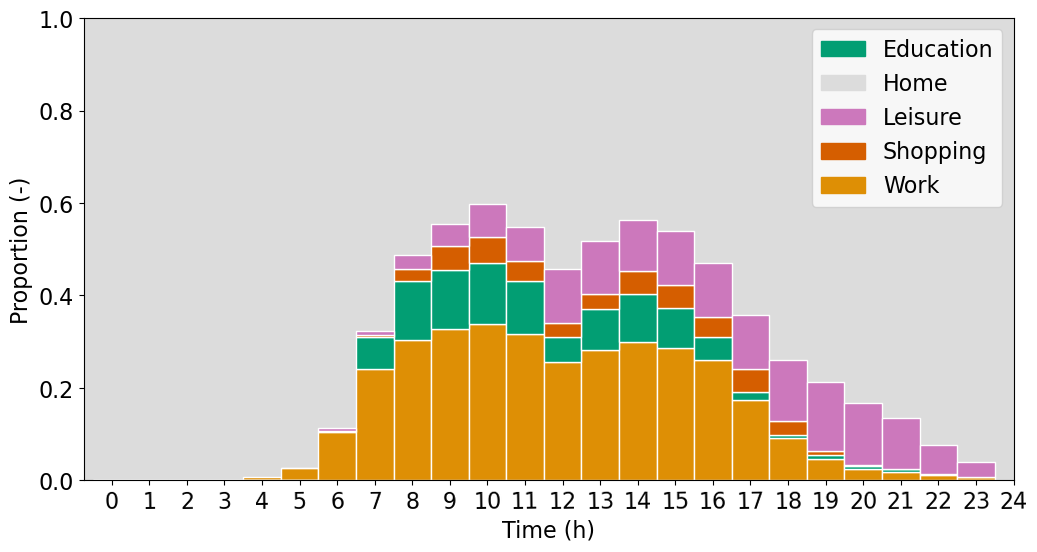

In [22]:
# All
plot_distribution(sample_24_wd, list_act)

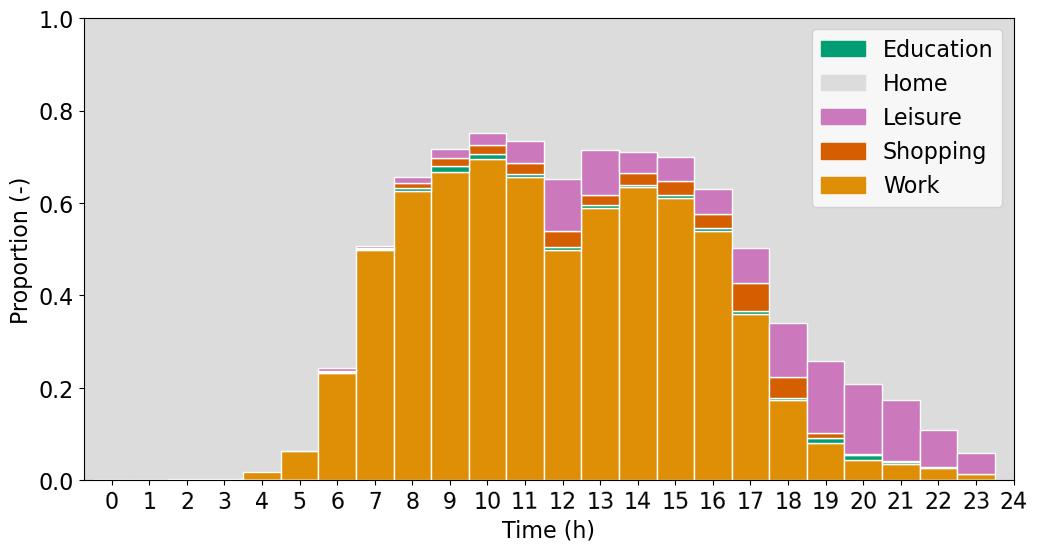

In [23]:
# Full-time worker
plot_distribution(sample_24_wd, list_act, emp=1)

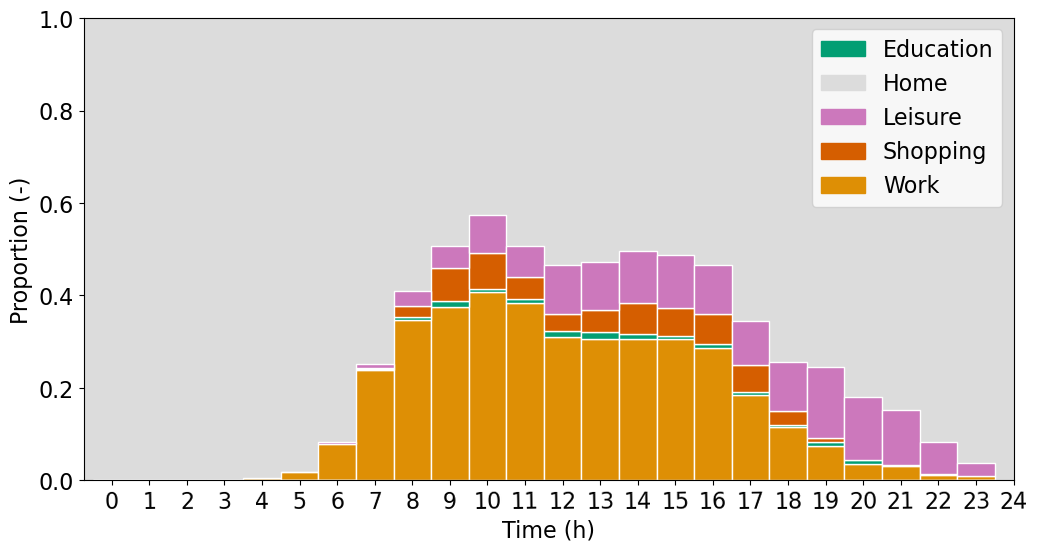

In [24]:
# Part-time worker
plot_distribution(sample_24_wd, list_act, emp=2)

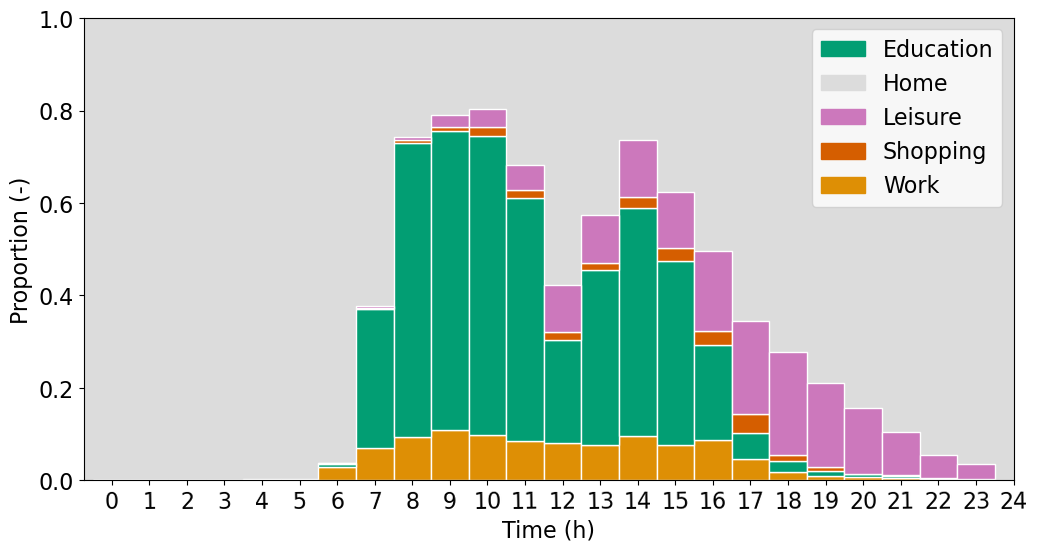

In [25]:
# Student
plot_distribution(sample_24_wd, list_act, emp=3)

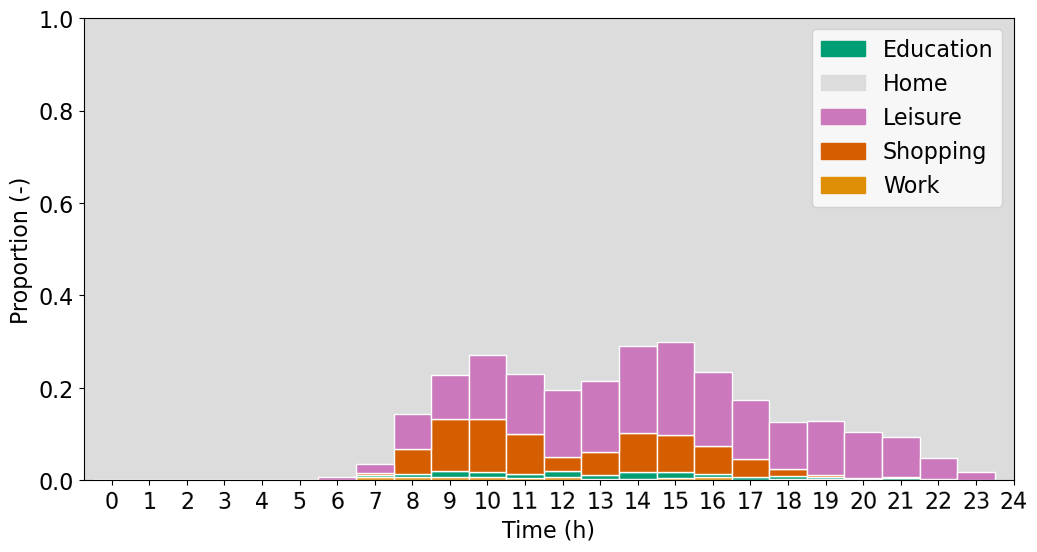

In [26]:
# Unemployed
plot_distribution(sample_24_wd, list_act, emp=4)

#### Weekend

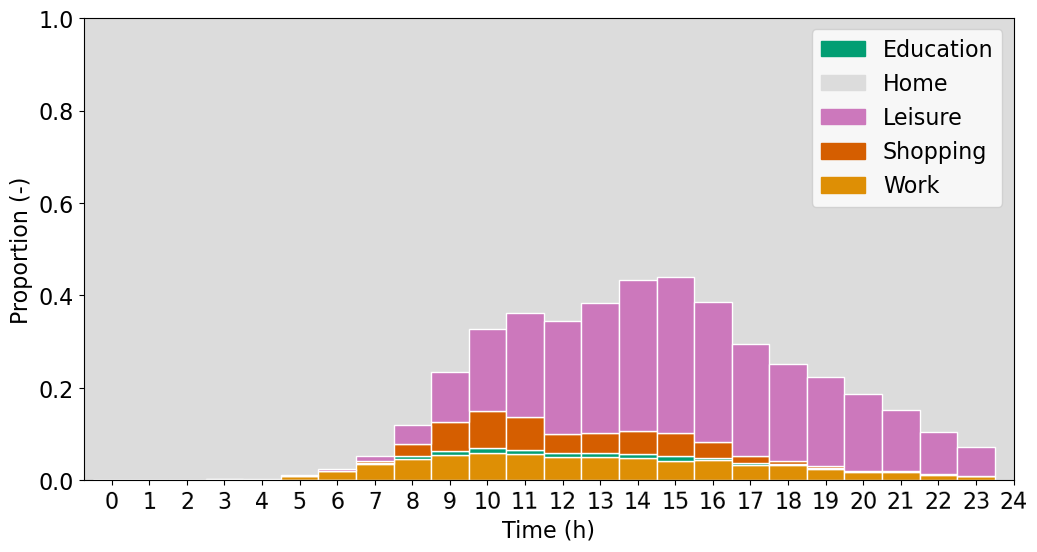

In [27]:
# All
plot_distribution(sample_24_we, list_act)

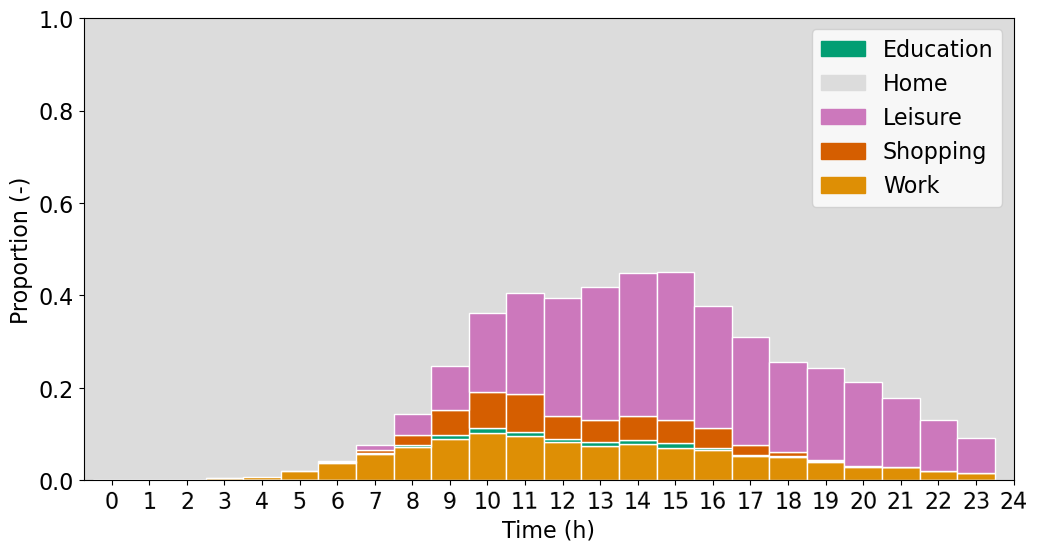

In [28]:
# Full-time worker
plot_distribution(sample_24_we, list_act, emp=1)

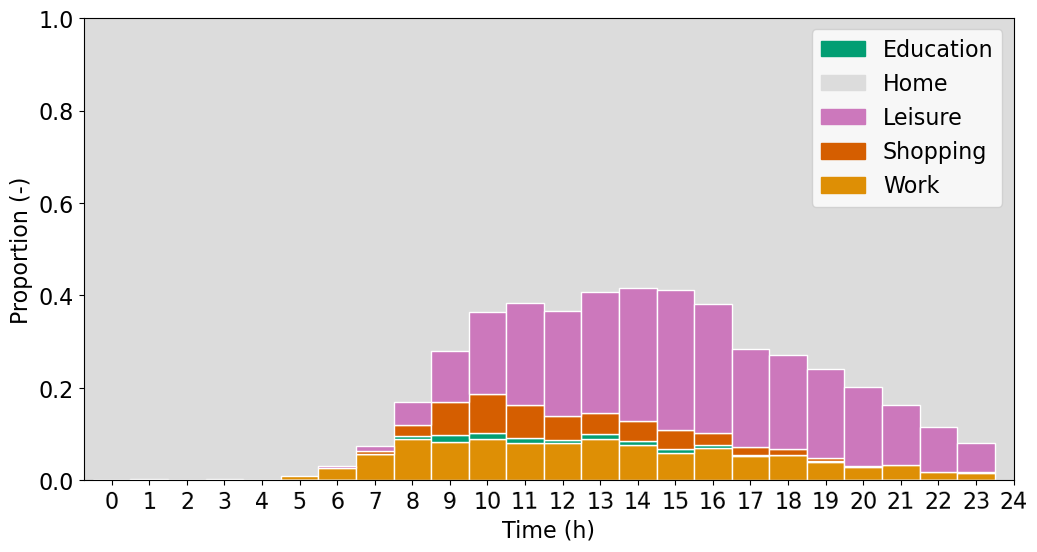

In [29]:
# Part-time worker
plot_distribution(sample_24_we, list_act, emp=2)

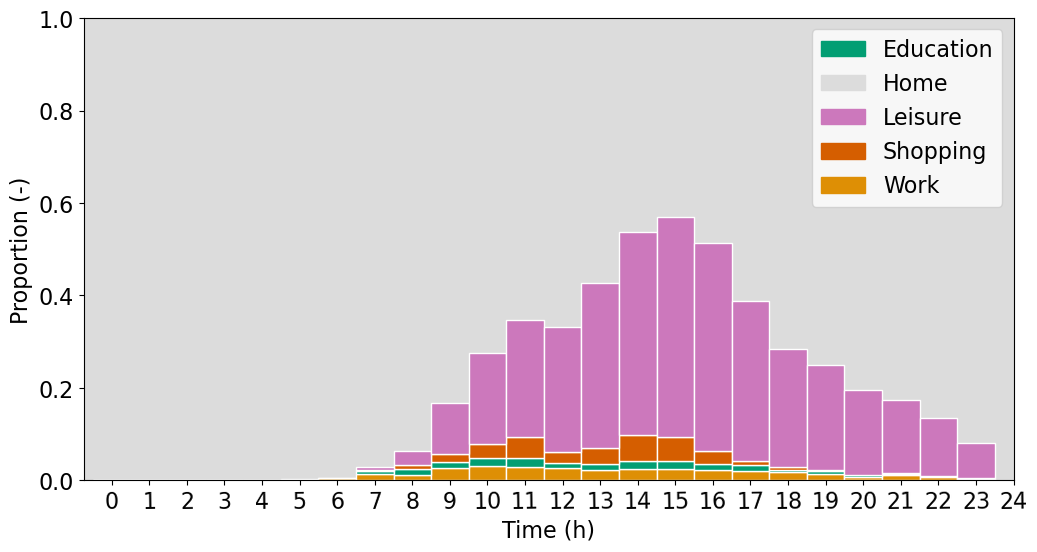

In [30]:
# Student
plot_distribution(sample_24_we, list_act, emp=3)

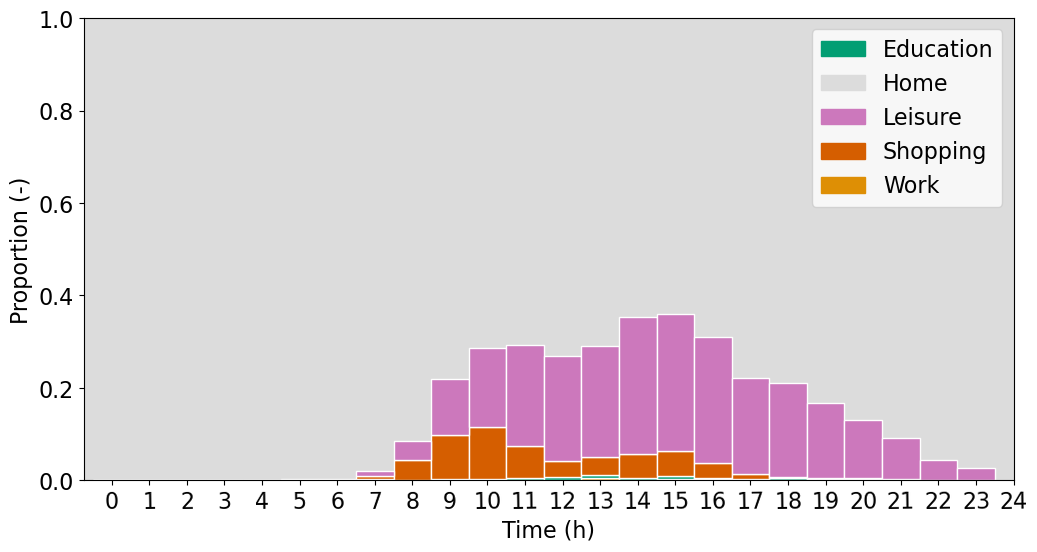

In [31]:
# Unemployed
plot_distribution(sample_24_we, list_act, emp=4)

## 3.2 10-MIN TIME SLOTS

#### Weekdays

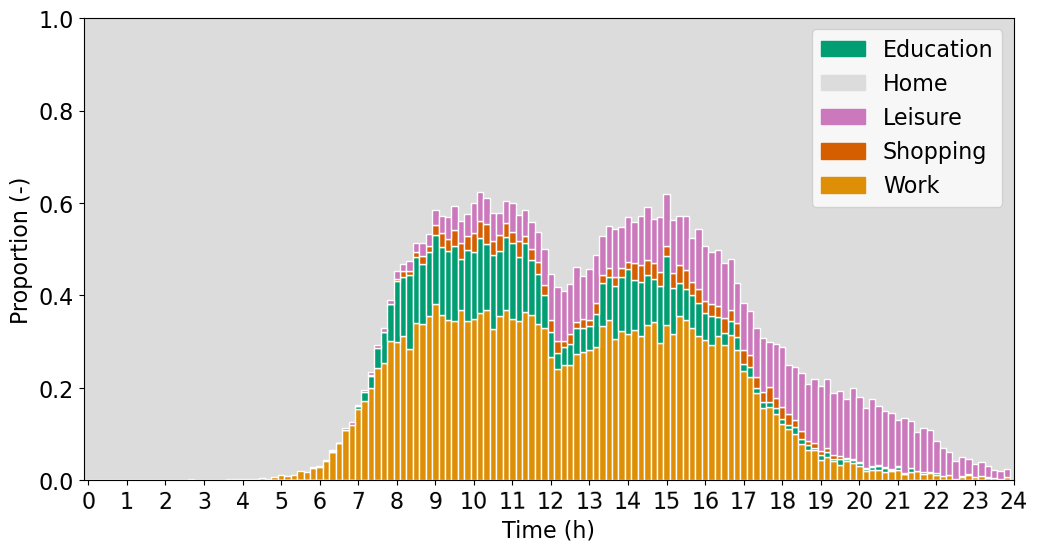

In [32]:
# All
plot_distribution(sample_144_wd, list_act)

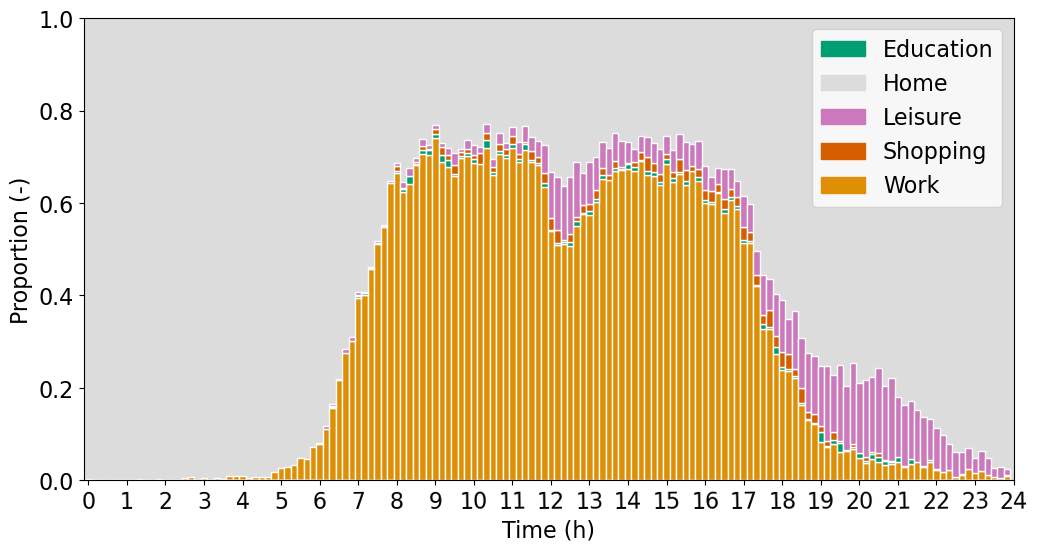

In [33]:
# Full-time worker
plot_distribution(sample_144_wd, list_act, emp=1)

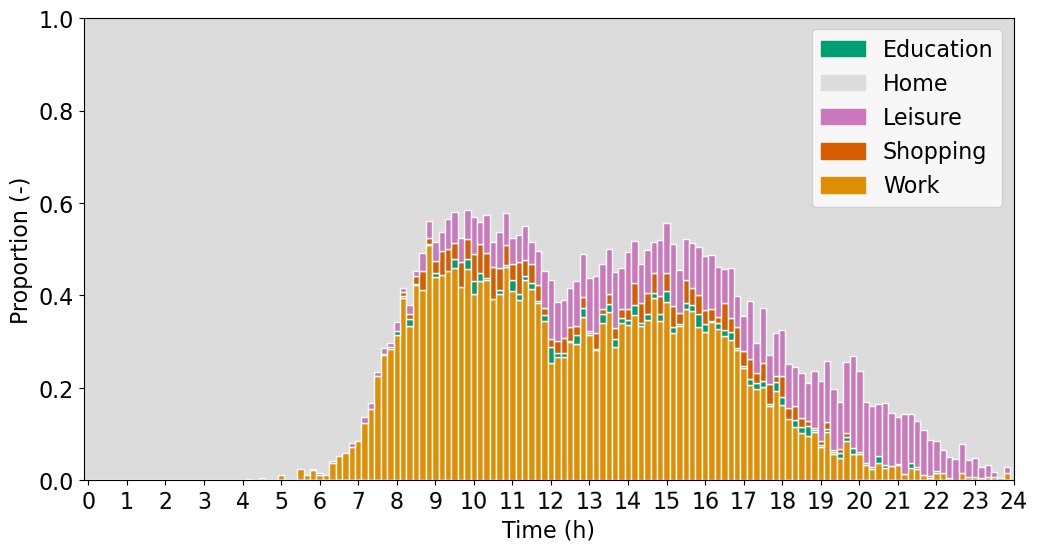

In [34]:
# Part-time worker
plot_distribution(sample_144_wd, list_act, emp=2)

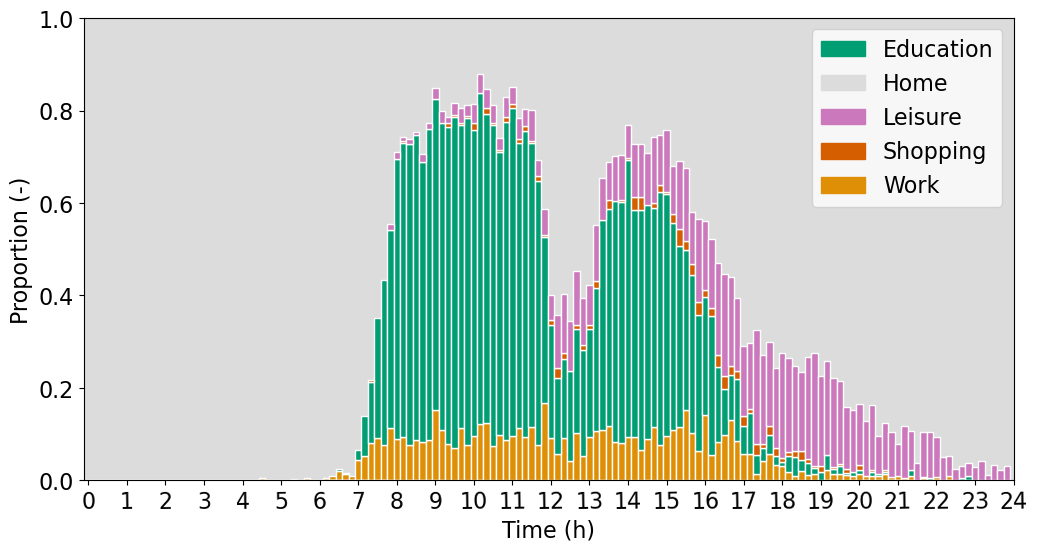

In [35]:
# Student
plot_distribution(sample_144_wd, list_act, emp=3)

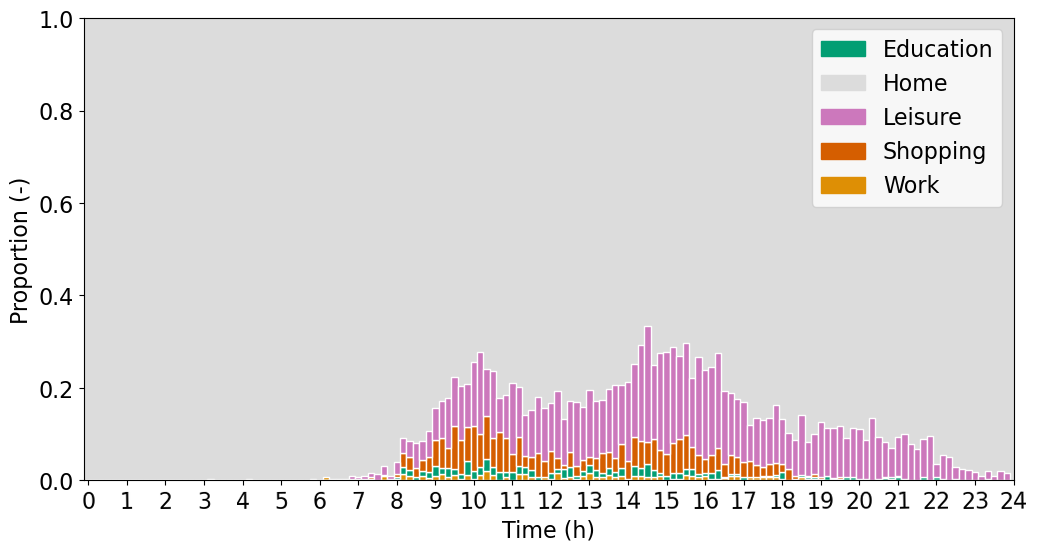

In [36]:
# Unemployed
plot_distribution(sample_144_wd, list_act, emp=4)

#### Weekend

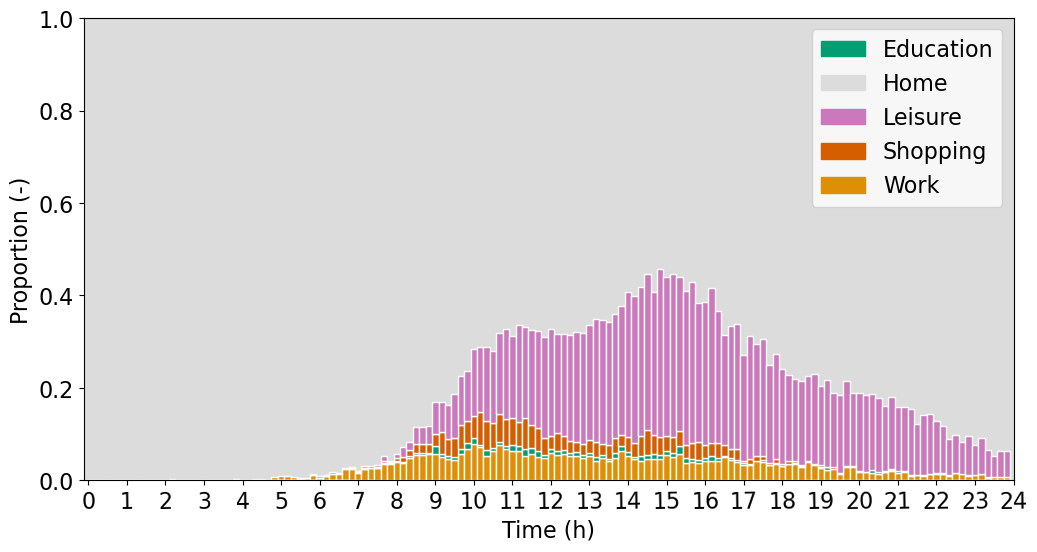

In [37]:
# All
plot_distribution(sample_144_we, list_act)

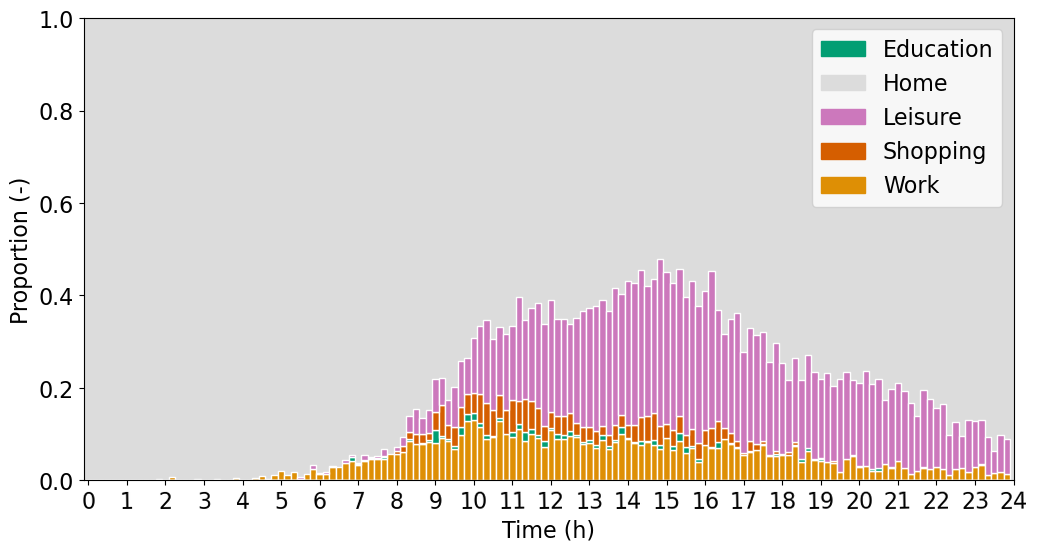

In [38]:
# Full-time worker
plot_distribution(sample_144_we, list_act, emp=1)

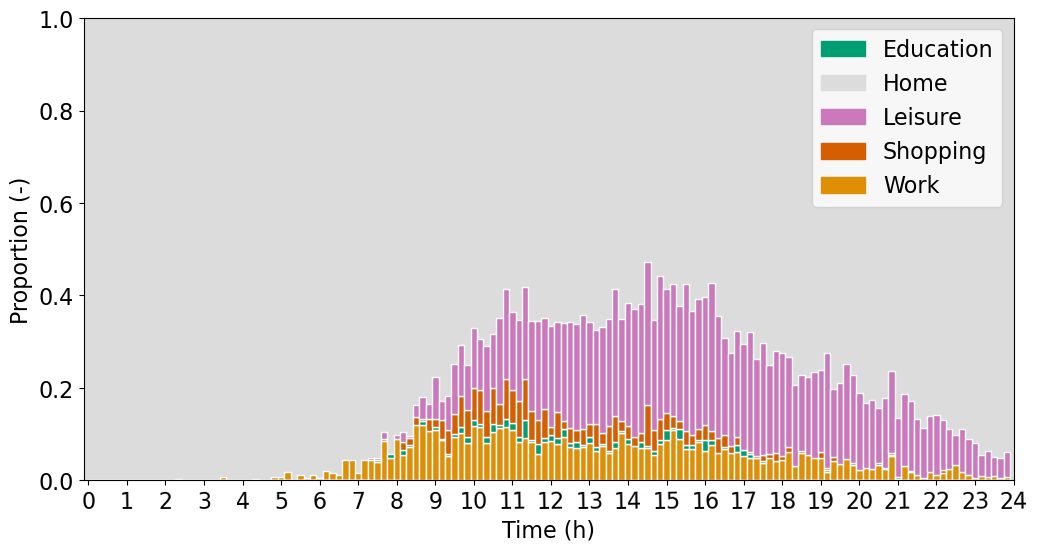

In [39]:
# Part-time worker
plot_distribution(sample_144_we, list_act, emp=2)

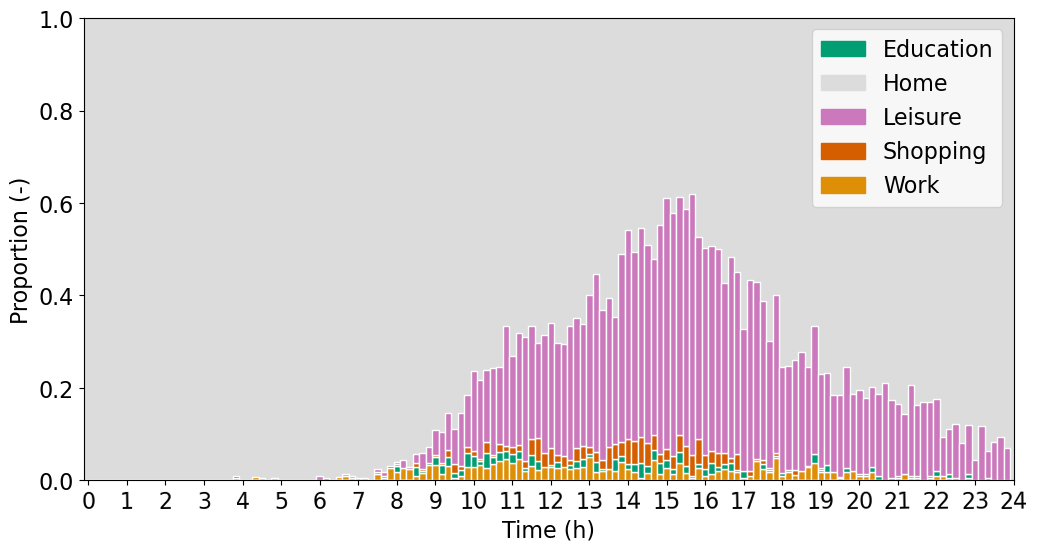

In [40]:
# Student
plot_distribution(sample_144_we, list_act, emp=3)

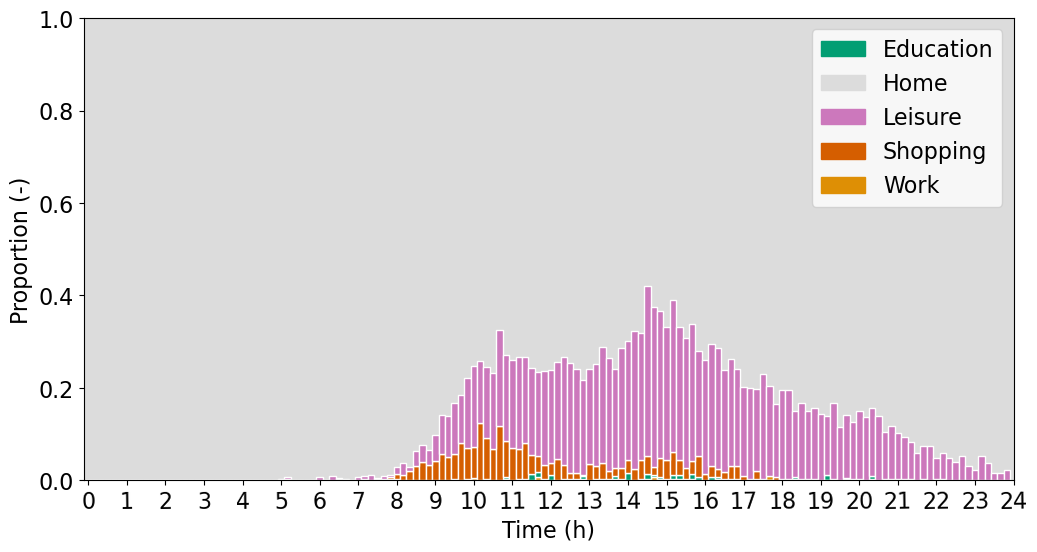

In [41]:
# Unemployed
plot_distribution(sample_144_we, list_act, emp=4)

## 4. PLOT ACTIVITIES DIFFERENCES

## 4.1 1-HOUR TIME SLOTS

#### Weekdays

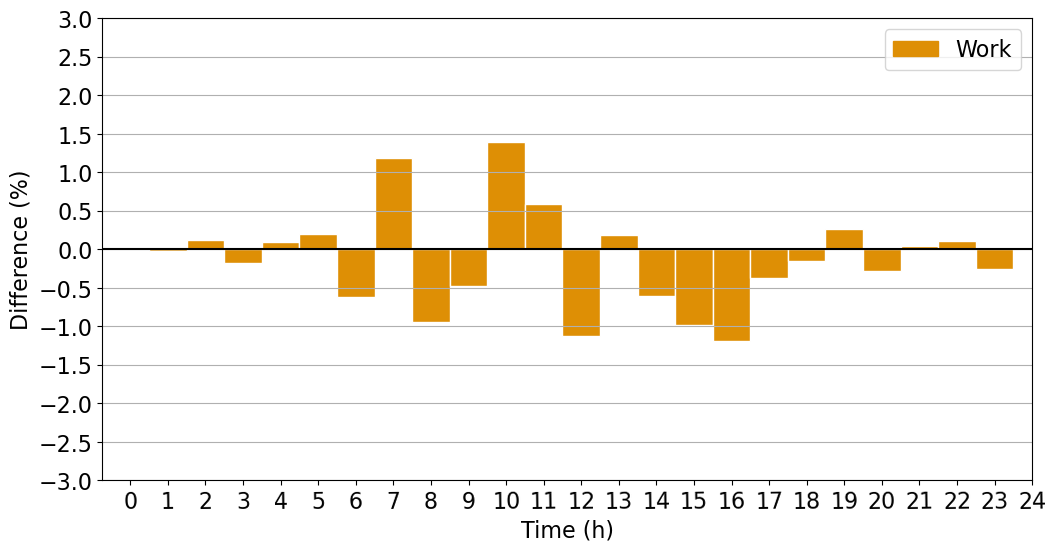

In [42]:
plot_differences(sample_24_wd, original_24_wd, list_act, 'Work', y_max=3, emp=1)

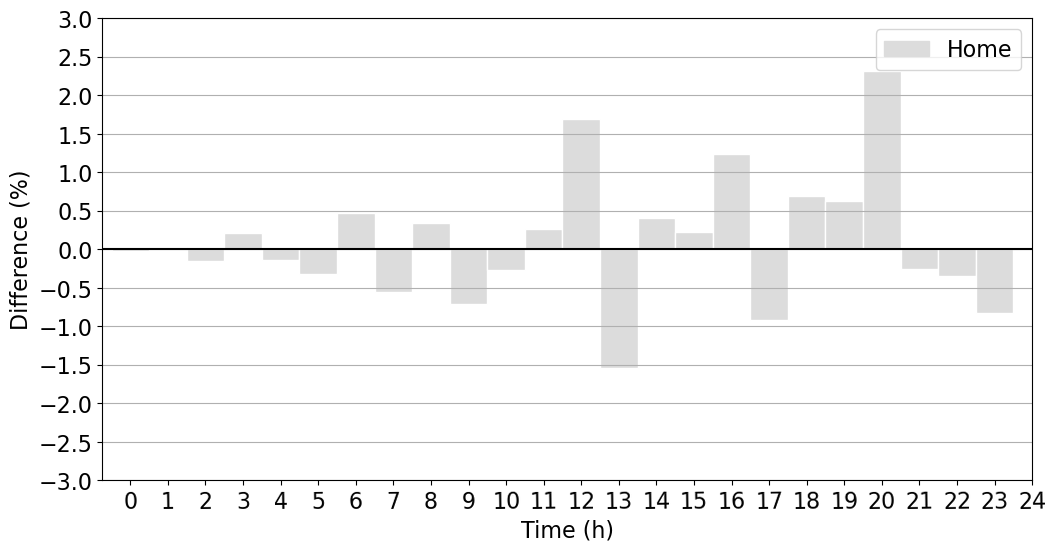

In [43]:
plot_differences(sample_24_wd, original_24_wd, list_act, 'Home', y_max=3, emp=1)

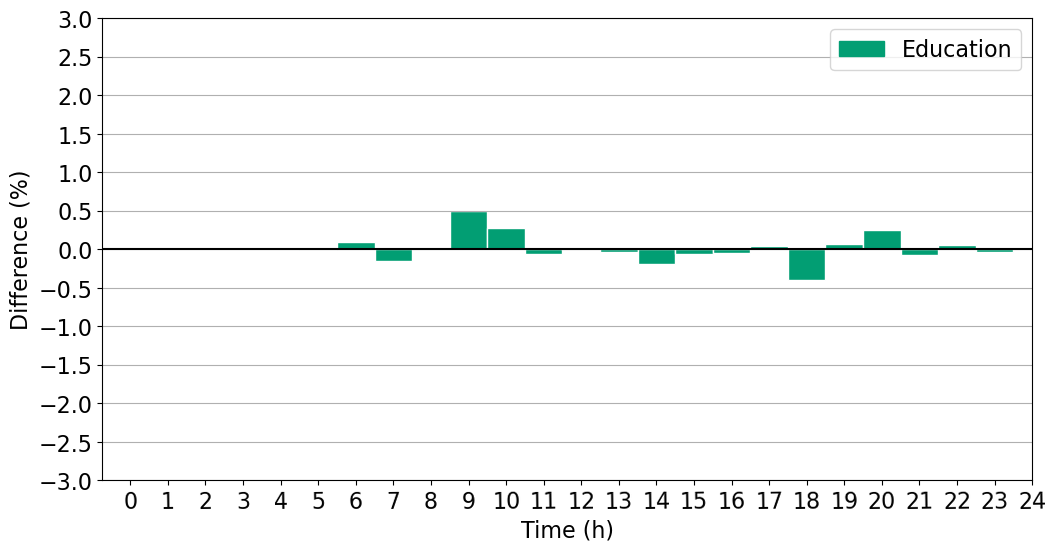

In [44]:
plot_differences(sample_24_wd, original_24_wd, list_act, 'Education', y_max=3, emp=1)

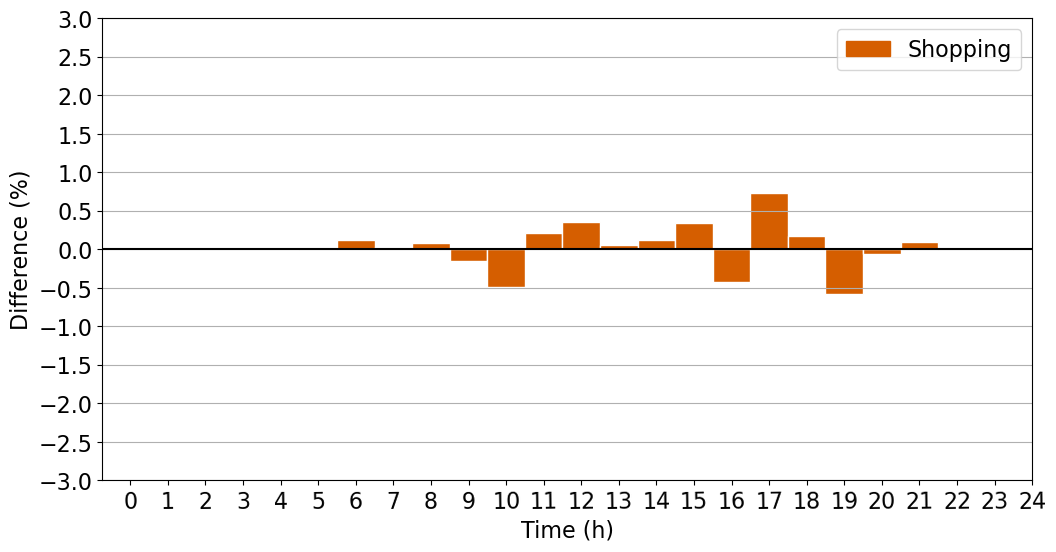

In [45]:
plot_differences(sample_24_wd, original_24_wd, list_act, 'Shopping', y_max=3, emp=1)

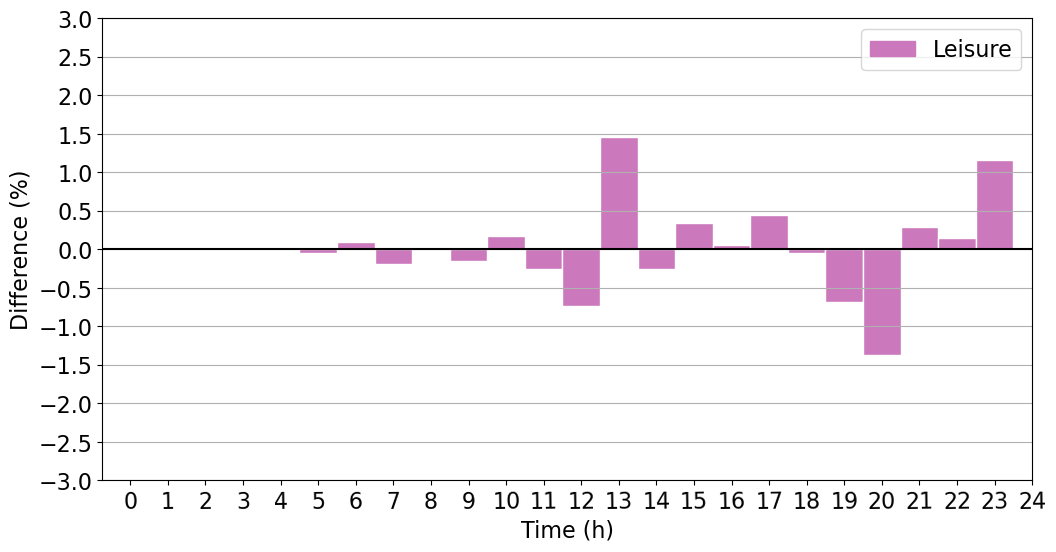

In [46]:
plot_differences(sample_24_wd, original_24_wd, list_act, 'Leisure', y_max=3, emp=1)

#### Week-end

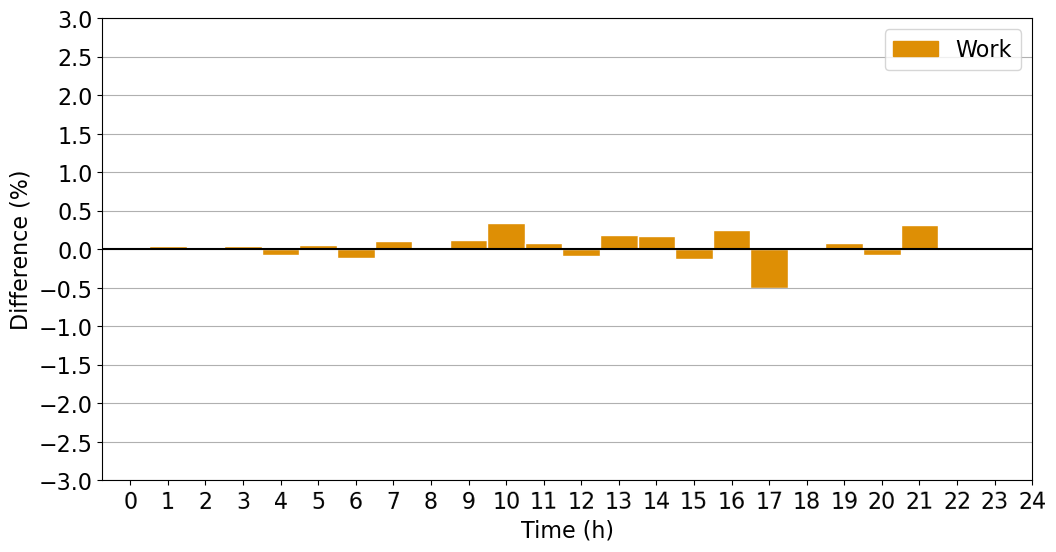

In [47]:
plot_differences(sample_24_we, original_24_we, list_act, 'Work', y_max=3)

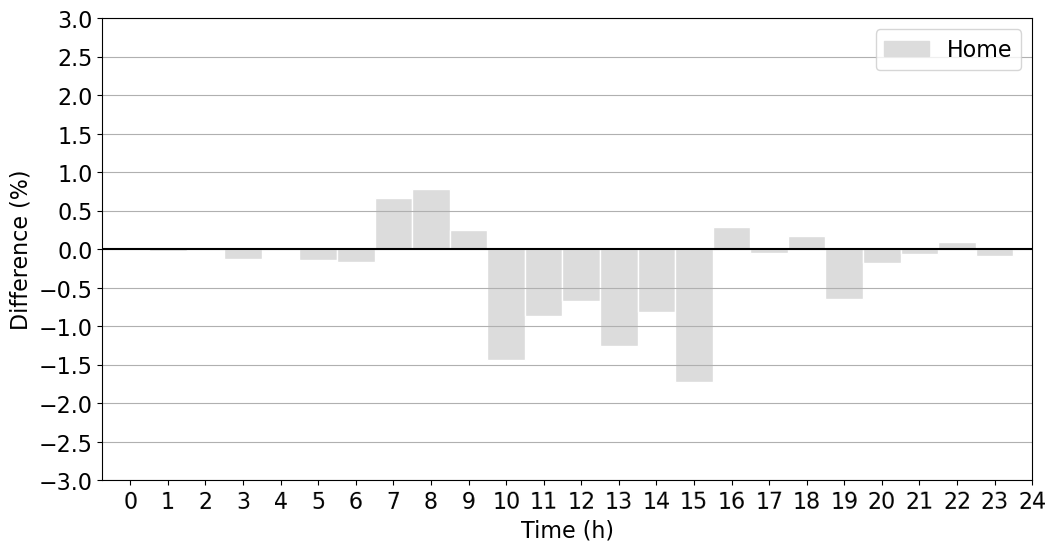

In [48]:
plot_differences(sample_24_we, original_24_we, list_act, 'Home', y_max=3, emp=1)

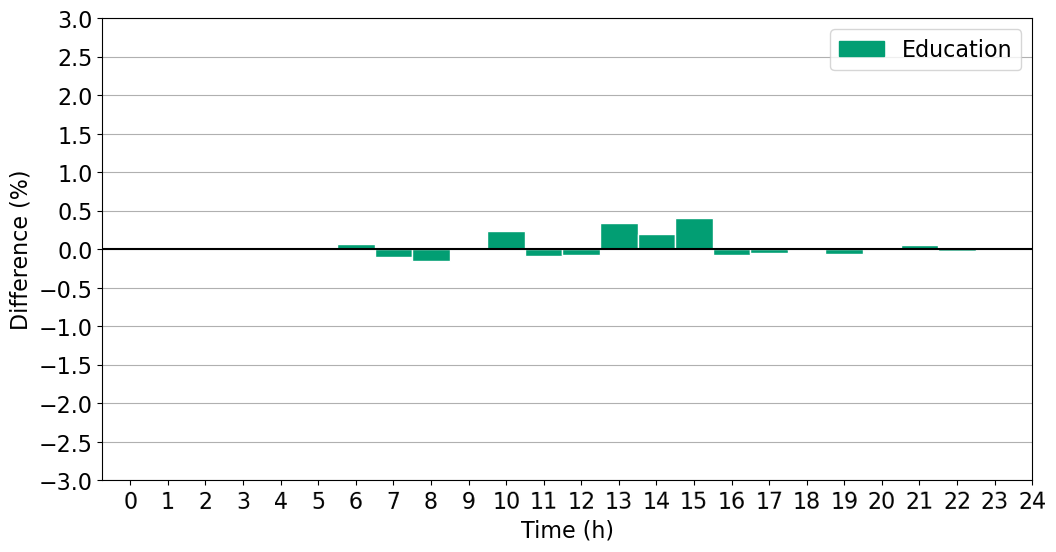

In [49]:
plot_differences(sample_24_we, original_24_we, list_act, 'Education', y_max=3, emp=1)

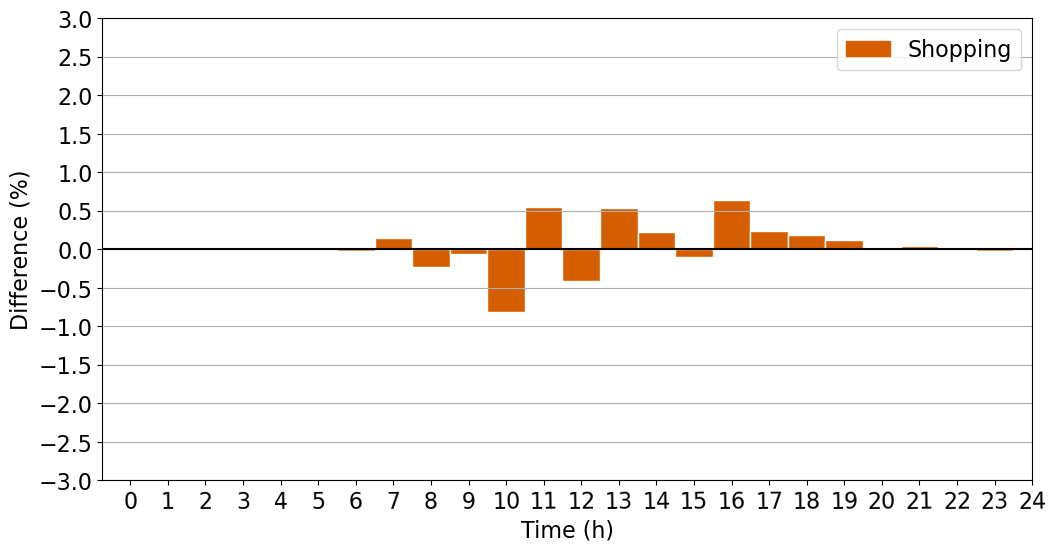

In [50]:
plot_differences(sample_24_we, original_24_we, list_act, 'Shopping', y_max=3, emp=1)

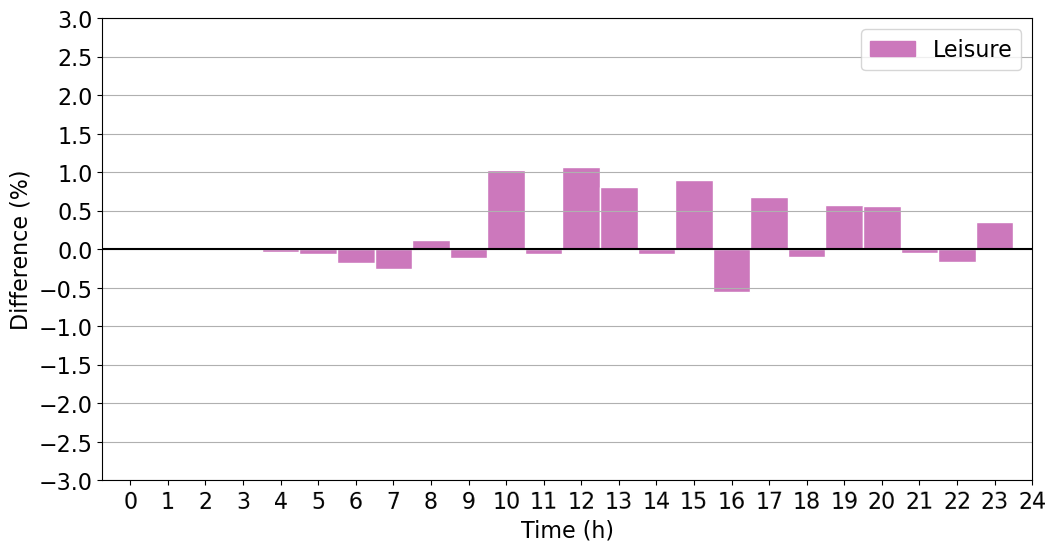

In [51]:
plot_differences(sample_24_we, original_24_we, list_act, 'Leisure', y_max=3, emp=1)

## 4.2 10-MIN TIME SLOTS

#### Weekdays

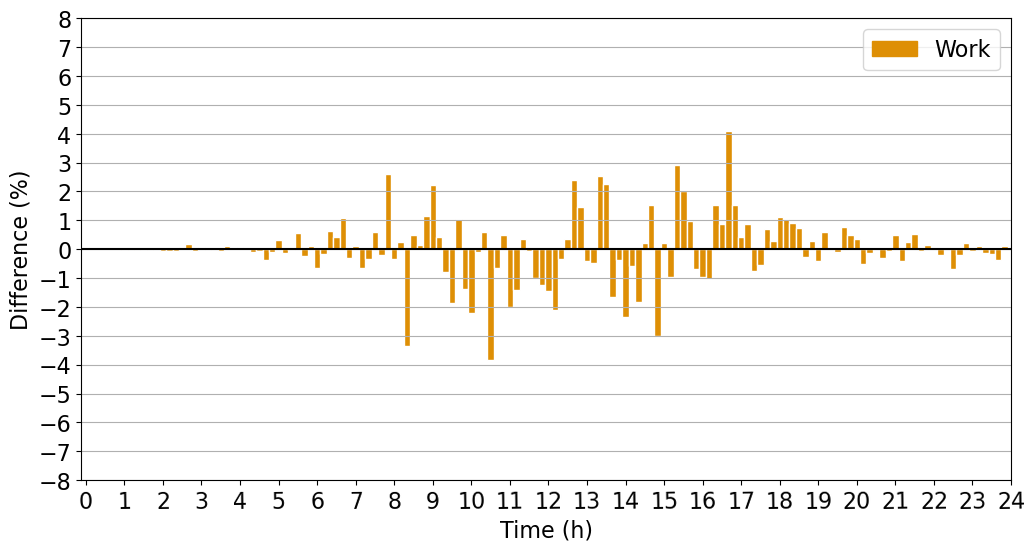

In [52]:
plot_differences(sample_144_wd, original_144_wd, list_act, 'Work', y_max=8, y_ticks=1)

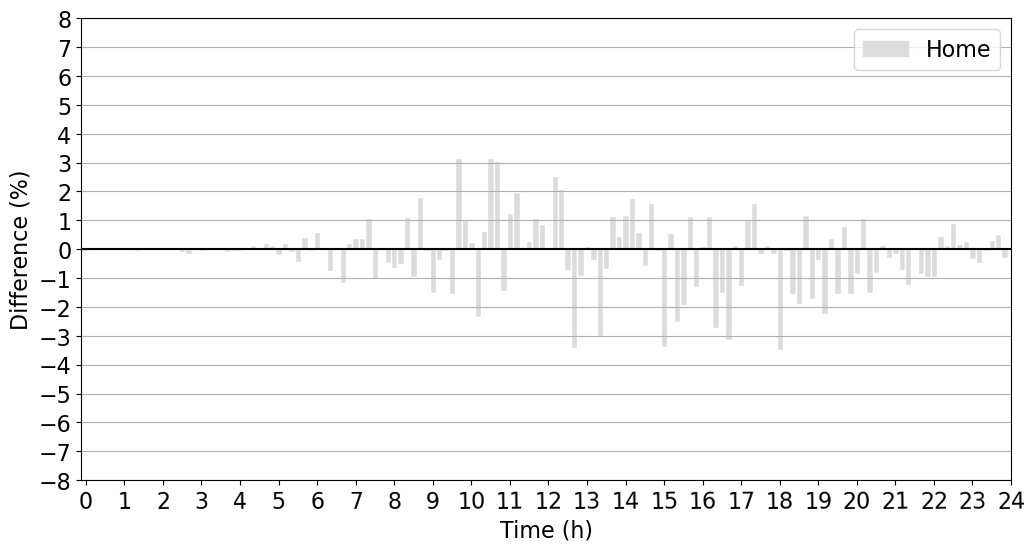

In [53]:
plot_differences(sample_144_wd, original_144_wd, list_act, 'Home', y_max=8, y_ticks=1)

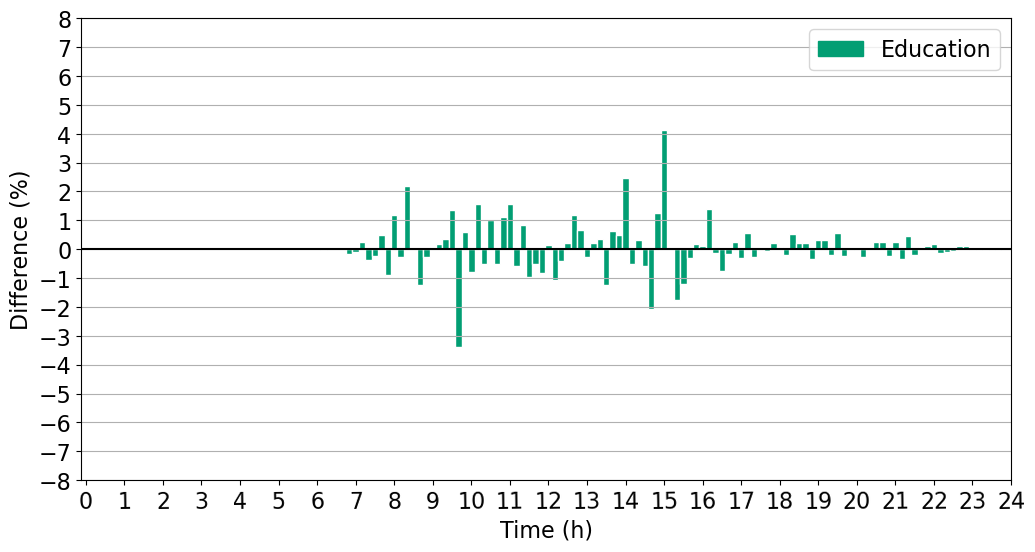

In [54]:
plot_differences(sample_144_wd, original_144_wd, list_act, 'Education', y_max=8, y_ticks=1)

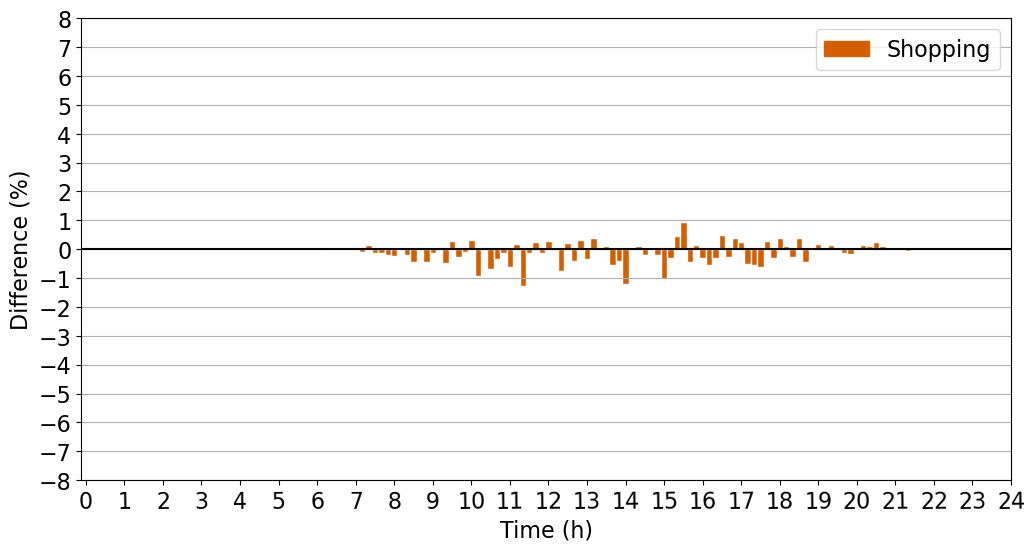

In [55]:
plot_differences(sample_144_wd, original_144_wd, list_act, 'Shopping', y_max=8, y_ticks=1)

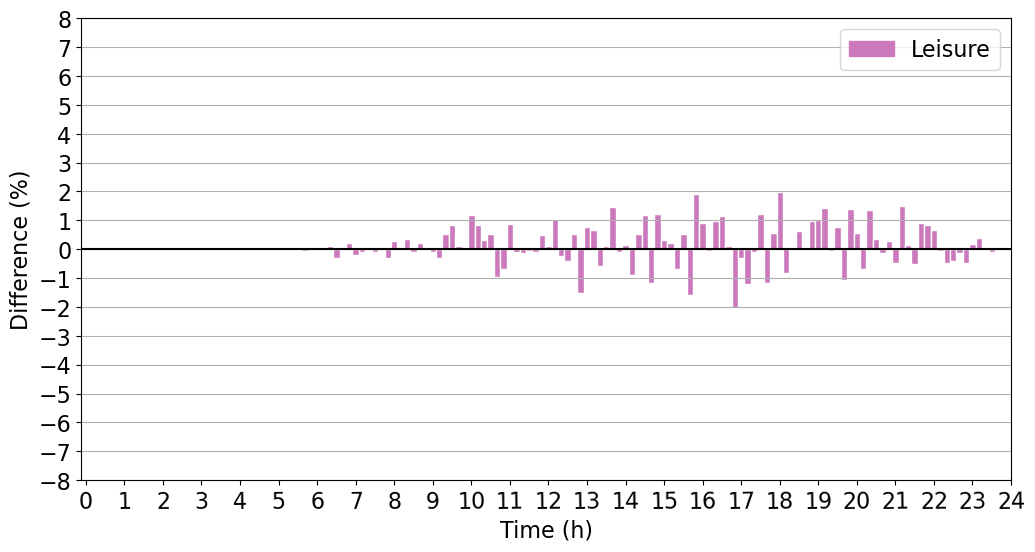

In [56]:
plot_differences(sample_144_wd, original_144_wd, list_act, 'Leisure', y_max=8, y_ticks=1)

#### Week-end

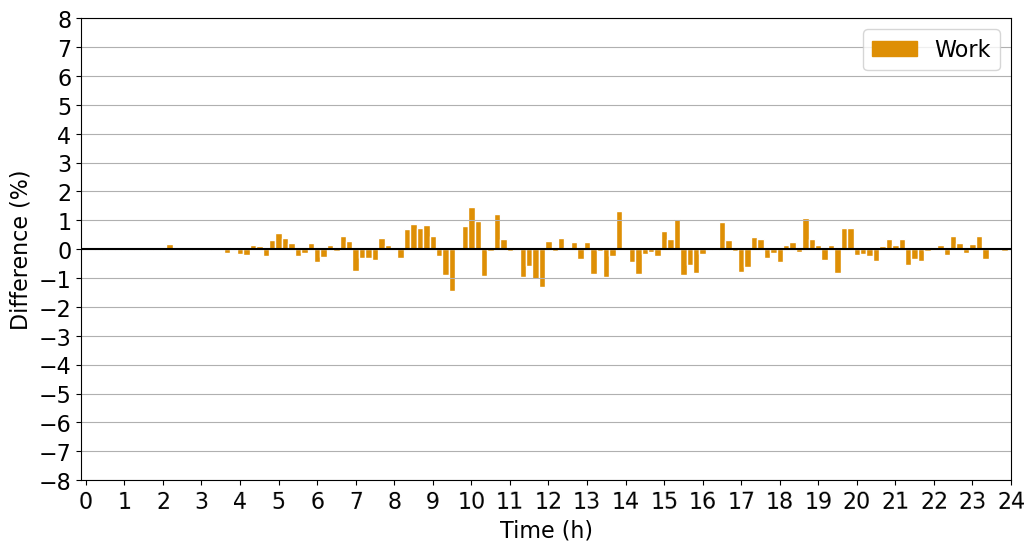

In [57]:
plot_differences(sample_144_we, original_144_we, list_act, 'Work', y_max=8, y_ticks=1)

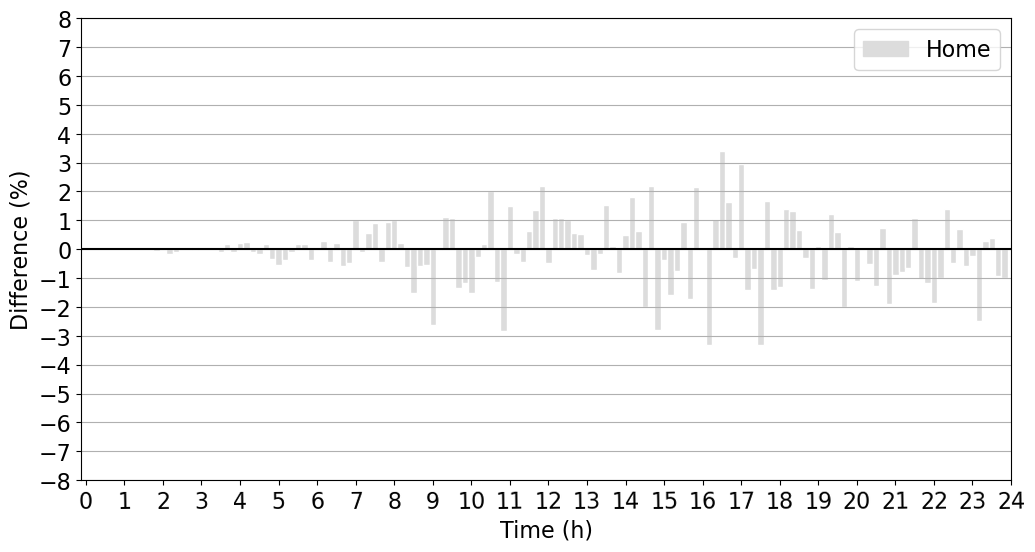

In [58]:
plot_differences(sample_144_we, original_144_we, list_act, 'Home', y_max=8, y_ticks=1)

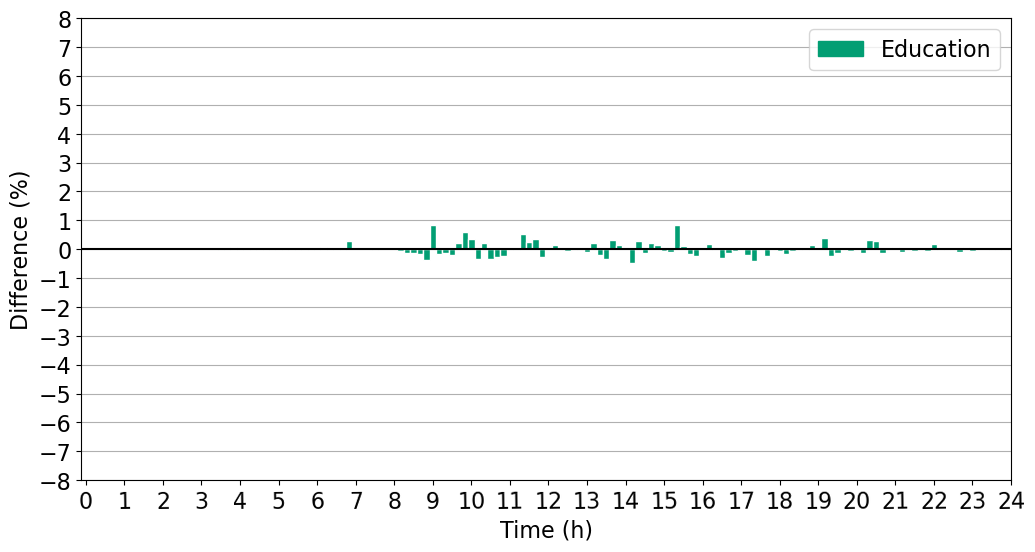

In [59]:
plot_differences(sample_144_we, original_144_we, list_act, 'Education', y_max=8, y_ticks=1)

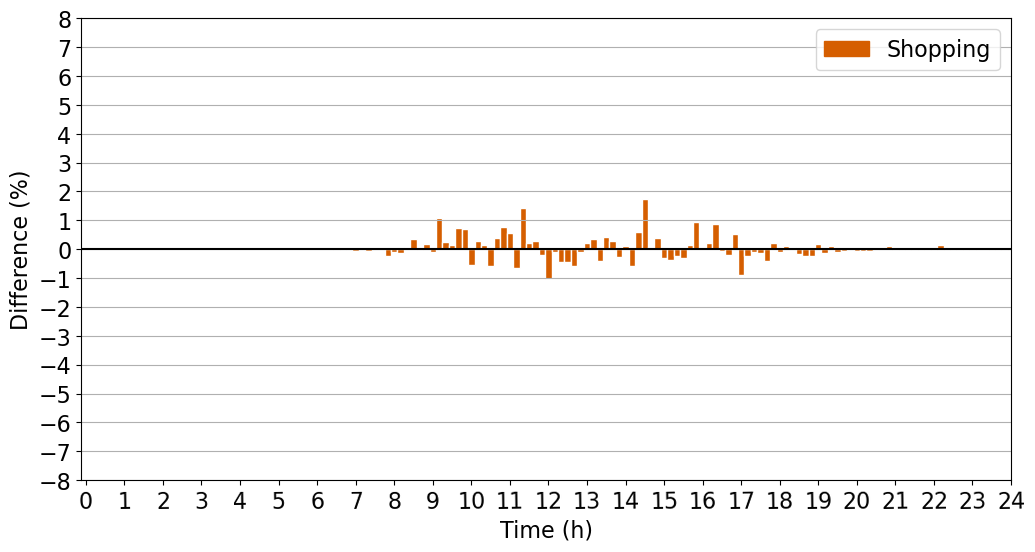

In [60]:
plot_differences(sample_144_we, original_144_we, list_act, 'Shopping', y_max=8, y_ticks=1)

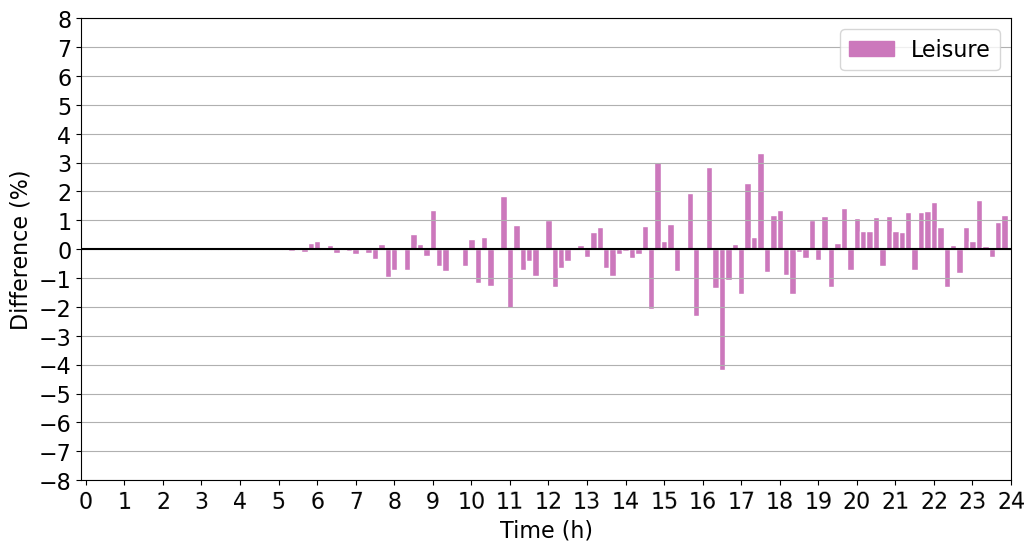

In [61]:
plot_differences(sample_144_we, original_144_we, list_act, 'Leisure', y_max=8, y_ticks=1)

## 5. PLOT DIFFERENCES

In [62]:
# Definition of time slots intervals
inter_6 = equal_dur_inter(6)
inter_24 = equal_dur_inter(24)
inter_144 = equal_dur_inter(144)

min_inter_6 = minutes_to_time(inter_6)
min_inter_24 = minutes_to_time(inter_24)

### 5.1 WEEKDAYS

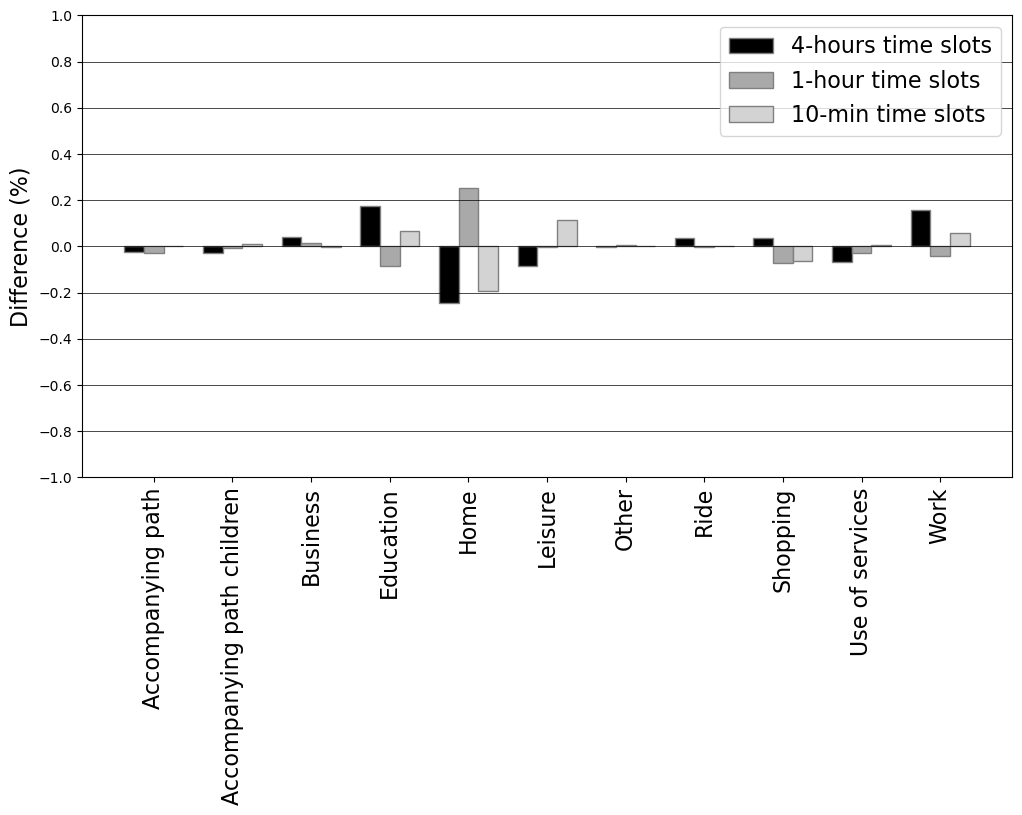

In [67]:
# Activities
plot_activities_diff_all(original_df_act_wd, sample_df_act_wd, 'activity', y_max=1, y_ticks=0.2, x_title='Activity type',
                         zoom=1, rotation=90)

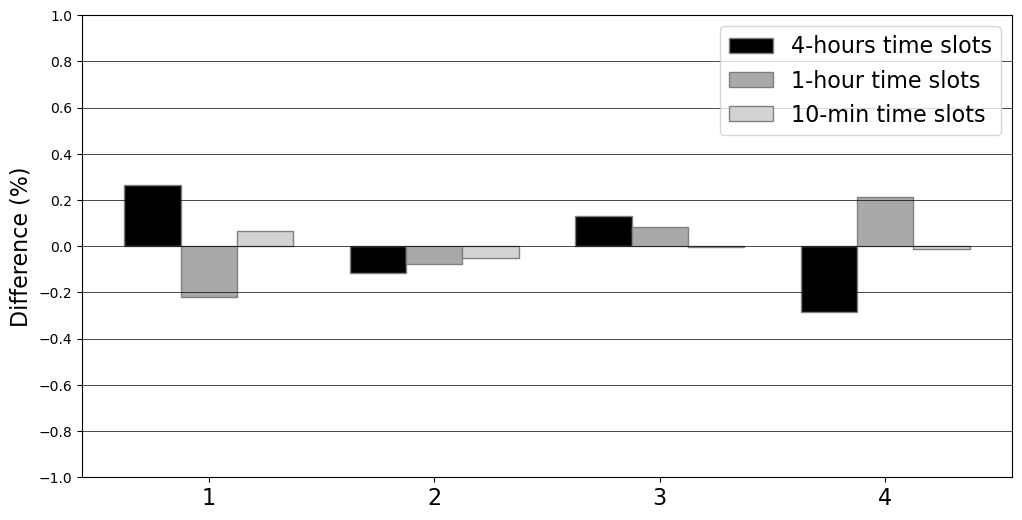

In [68]:
# Employment status
plot_activities_diff_all(original_df_wd, sample_df_wd, 'emp', y_max=1, y_ticks=0.2, x_title='Employment status')

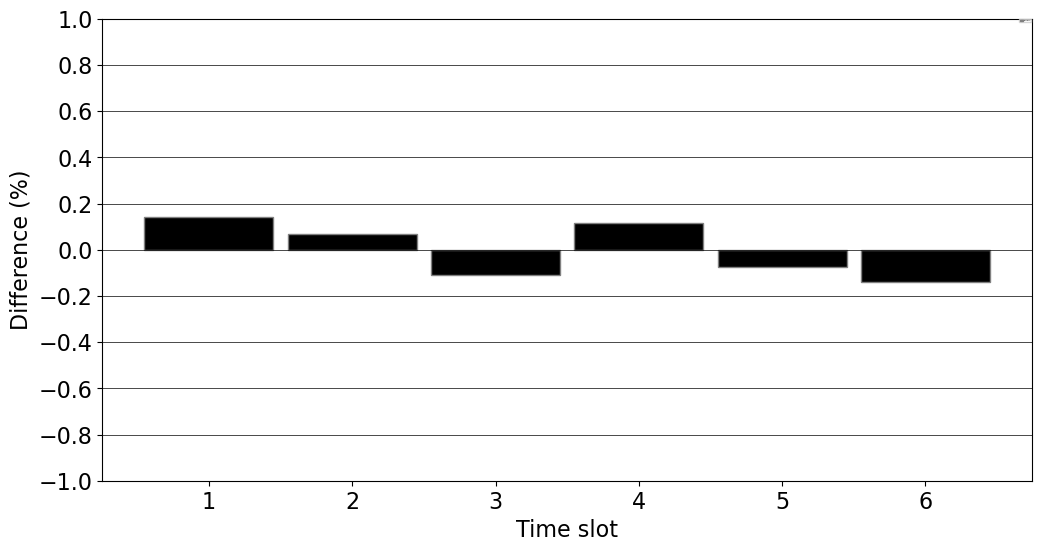

In [71]:
# Slots 6
plot_activities_diff(original_6_wd, sample_6_wd, 'slot', y_ticks=0.2, rotation=0, zoom=1, figsize=(12,6),
                     x_title='Time slot', y_max=1)

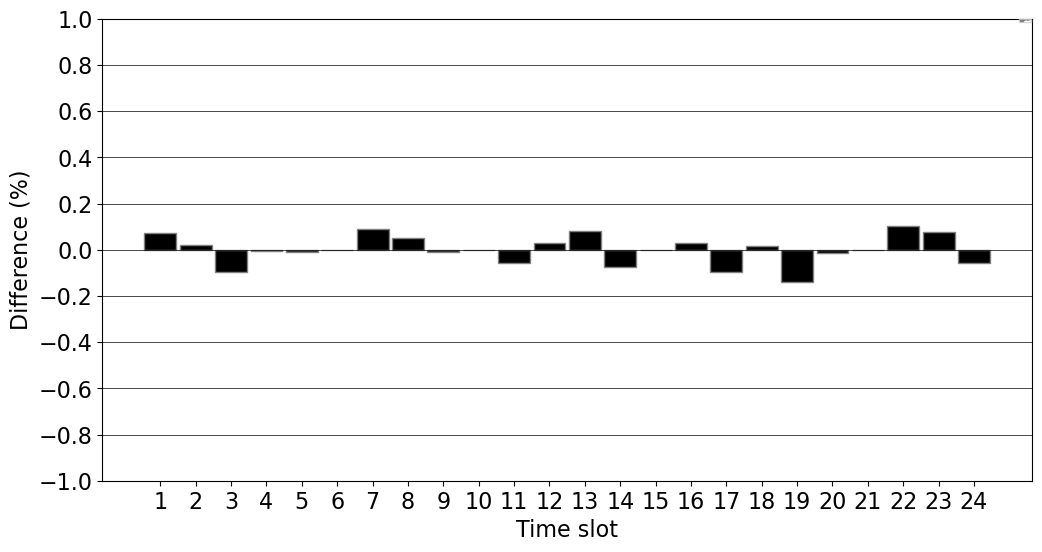

In [72]:
# Slots 24
plot_activities_diff(original_24_wd, sample_24_wd, 'slot', y_ticks=0.2, rotation=0, zoom=1, figsize=(12,6),
                     x_title='Time slot', y_max=1)

### 5.2 WEEKEND

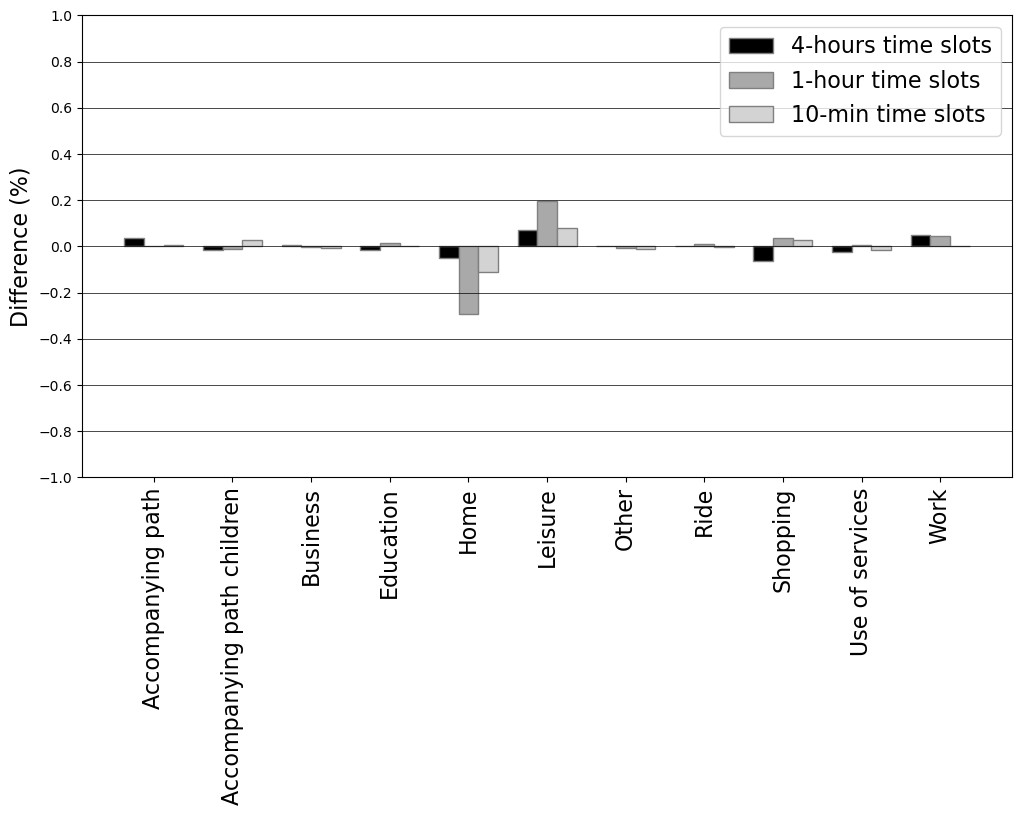

In [73]:
# Activities
plot_activities_diff_all(original_df_act_we, sample_df_act_we, 'activity', y_max=1, y_ticks=0.2, x_title='Activity type',
                         zoom=1, rotation=90)

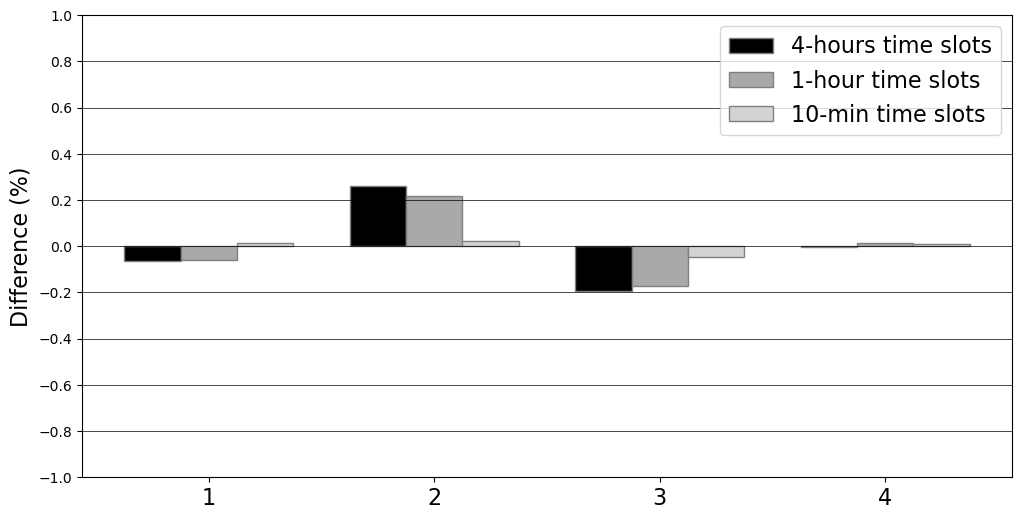

In [75]:
# Employment status
plot_activities_diff_all(original_df_we, sample_df_we, 'emp', y_max=1, y_ticks=0.2, x_title='Employment status')

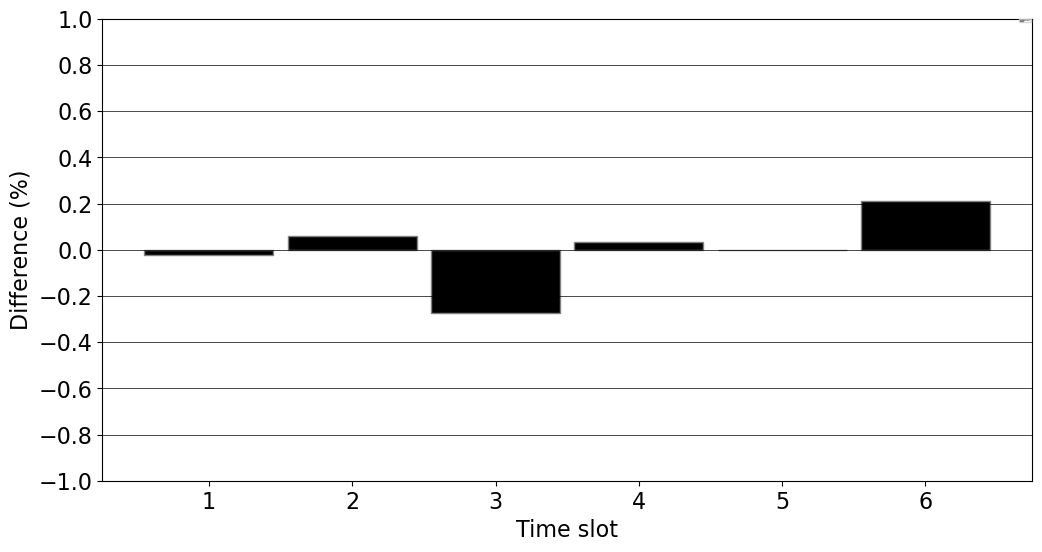

In [76]:
# Slots 6
plot_activities_diff(original_6_we, sample_6_we, 'slot', y_ticks=0.2, rotation=0, zoom=1, figsize=(12,6),
                     x_title='Time slot', y_max=1)

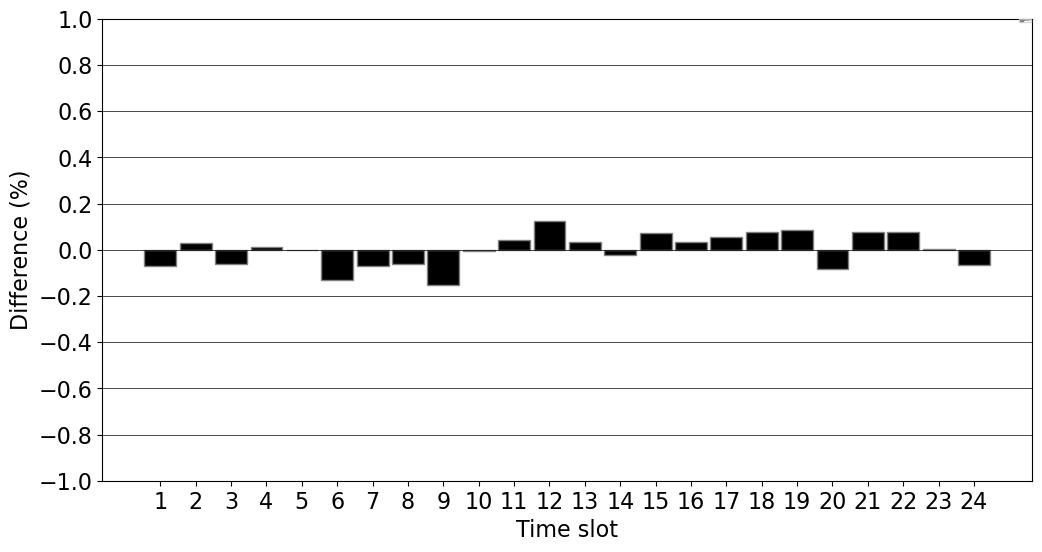

In [77]:
# Slots 24
plot_activities_diff(original_24_we, sample_24_we, 'slot', y_ticks=0.2, rotation=0, zoom=1, figsize=(12,6),
                     x_title='Time slot', y_max=1)

## 6. LIST OF PREFERRED ACTIVITIES

### 6.1 4-HOURS TIME SLOTS

#### WEEKDAYS

In [87]:
# Sample
most_common_activities_sample_6 = get_most_common_activities(sample_6_wd)
most_df_sample_6 = create_most_df(most_common_activities_sample_6)

# Original
most_common_activities_original_6 = get_most_common_activities(original_6_wd)
most_df_original_6 = create_most_df(most_common_activities_original_6)

In [88]:
output_most_act(most_common_activities_sample_6, 3, inter_6)

Activity for emp 1, slot 1 (00:00-04:00): 0 (99.52 % [7037]); 2 (0.45 % [32]); 6 (0.03 % [2])
Activity for emp 1, slot 2 (04:00-08:00): 0 (60.61 % [6839]); 2 (34.46 % [3889]); 6 (2.68 % [302])
Activity for emp 1, slot 3 (08:00-12:00): 2 (53.98 % [5281]); 0 (24.81 % [2427]); 6 (6.87 % [672])
Activity for emp 1, slot 4 (12:00-16:00): 2 (48.45 % [5617]); 0 (25.91 % [3004]); 8 (10.67 % [1237])
Activity for emp 1, slot 5 (16:00-20:00): 0 (45.31 % [6676]); 2 (28.59 % [4213]); 8 (11.7 % [1724])
Activity for emp 1, slot 6 (20:00-24:00): 0 (78.27 % [6732]); 8 (15.09 % [1298]); 2 (4.21 % [362])

Principal motif for emp 1: 0, 2, 0

Activity for emp 2, slot 1 (00:00-04:00): 0 (99.82 % [3908]); 2 (0.18 % [7])
Activity for emp 2, slot 2 (04:00-08:00): 0 (74.52 % [3907]); 2 (20.98 % [1100]); 8 (1.32 % [69])
Activity for emp 2, slot 3 (08:00-12:00): 0 (47.16 % [3310]); 2 (25.57 % [1795]); 4 (10.6 % [744])
Activity for emp 2, slot 4 (12:00-16:00): 0 (44.2 % [3229]); 2 (25.75 % [1881]); 8 (11.91 % [870]

In [89]:
output_most_act(most_common_activities_original_6, 3, inter_6)

Activity for emp 1, slot 1 (00:00-04:00): 0 (99.46 % [10764]); 2 (0.51 % [55]); 6 (0.02 % [2])
Activity for emp 1, slot 2 (04:00-08:00): 0 (61.18 % [10753]); 2 (33.89 % [5957]); 6 (2.66 % [467])
Activity for emp 1, slot 3 (08:00-12:00): 2 (53.35 % [8033]); 0 (25.47 % [3835]); 6 (6.78 % [1021])
Activity for emp 1, slot 4 (12:00-16:00): 2 (47.83 % [8597]); 0 (25.93 % [4661]); 8 (11.19 % [2011])
Activity for emp 1, slot 5 (16:00-20:00): 0 (44.92 % [10235]); 2 (29.18 % [6649]); 8 (11.85 % [2700])
Activity for emp 1, slot 6 (20:00-24:00): 0 (78.48 % [10626]); 8 (14.62 % [1979]); 2 (4.25 % [575])

Principal motif for emp 1: 0, 2, 0

Activity for emp 2, slot 1 (00:00-04:00): 0 (99.82 % [6129]); 2 (0.15 % [9]); 8 (0.02 % [1])
Activity for emp 2, slot 2 (04:00-08:00): 0 (75.63 % [6209]); 2 (20.28 % [1665]); 8 (1.04 % [85])
Activity for emp 2, slot 3 (08:00-12:00): 0 (47.35 % [5331]); 2 (25.58 % [2880]); 4 (10.67 % [1201])
Activity for emp 2, slot 4 (12:00-16:00): 0 (43.94 % [4944]); 2 (25.5 % [

#### WEEKEND

In [90]:
# Sample
most_common_activities_sample_6 = get_most_common_activities(sample_6_we)
most_df_sample_6 = create_most_df(most_common_activities_sample_6)

# Original
most_common_activities_original_6 = get_most_common_activities(original_6_we)
most_df_original_6 = create_most_df(most_common_activities_original_6)

In [91]:
output_most_act(most_common_activities_sample_6, 3, inter_6)

Activity for emp 1, slot 1 (00:00-04:00): 0 (99.57 % [7668]); 2 (0.38 % [29]); 8 (0.03 % [2])
Activity for emp 1, slot 2 (04:00-08:00): 0 (90.96 % [7654]); 2 (5.75 % [484]); 8 (1.31 % [110])
Activity for emp 1, slot 3 (08:00-12:00): 0 (62.12 % [8257]); 8 (16.9 % [2246]); 4 (9.63 % [1280])
Activity for emp 1, slot 4 (12:00-16:00): 0 (52.91 % [6789]); 8 (28.49 % [3656]); 4 (8.17 % [1048])
Activity for emp 1, slot 5 (16:00-20:00): 0 (61.11 % [7399]); 8 (27.15 % [3287]); 2 (5.29 % [640])
Activity for emp 1, slot 6 (20:00-24:00): 0 (79.4 % [7435]); 8 (16.3 % [1526]); 2 (3.03 % [284])

Principal motif for emp 1: 0

Activity for emp 2, slot 1 (00:00-04:00): 0 (99.66 % [4426]); 2 (0.2 % [9]); 6 (0.14 % [6])
Activity for emp 2, slot 2 (04:00-08:00): 0 (92.14 % [4466]); 2 (5.65 % [274]); 8 (0.83 % [40])
Activity for emp 2, slot 3 (08:00-12:00): 0 (62.78 % [4855]); 8 (16.8 % [1299]); 4 (10.73 % [830])
Activity for emp 2, slot 4 (12:00-16:00): 0 (53.43 % [3904]); 8 (27.45 % [2006]); 4 (8.49 % [620

In [92]:
output_most_act(most_common_activities_original_6, 3, inter_6)

Activity for emp 1, slot 1 (00:00-04:00): 0 (99.62 % [3381]); 2 (0.32 % [11]); 8 (0.03 % [1])
Activity for emp 1, slot 2 (04:00-08:00): 0 (91.27 % [3410]); 2 (5.57 % [208]); 8 (1.31 % [49])
Activity for emp 1, slot 3 (08:00-12:00): 0 (62.05 % [3689]); 8 (16.7 % [993]); 4 (9.99 % [594])
Activity for emp 1, slot 4 (12:00-16:00): 0 (52.96 % [2978]); 8 (28.47 % [1601]); 4 (8.15 % [458])
Activity for emp 1, slot 5 (16:00-20:00): 0 (60.89 % [3279]); 8 (27.28 % [1469]); 2 (5.29 % [285])
Activity for emp 1, slot 6 (20:00-24:00): 0 (79.36 % [3218]); 8 (16.6 % [673]); 2 (2.91 % [118])

Principal motif for emp 1: 0

Activity for emp 2, slot 1 (00:00-04:00): 0 (99.74 % [1920]); 2 (0.16 % [3]); 6 (0.1 % [2])
Activity for emp 2, slot 2 (04:00-08:00): 0 (92.73 % [1925]); 2 (5.11 % [106]); 8 (0.96 % [20])
Activity for emp 2, slot 3 (08:00-12:00): 0 (63.02 % [2140]); 8 (16.67 % [566]); 4 (10.51 % [357])
Activity for emp 2, slot 4 (12:00-16:00): 0 (53.98 % [1730]); 8 (27.24 % [873]); 4 (8.11 % [260])
Ac

### 6.2 1-HOUR TIME SLOTS

#### WEEKDAYS

In [93]:
# sample
most_common_activities_sample_24 = get_most_common_activities(sample_24_wd)
most_df_sample_24 = create_most_df(most_common_activities_sample_24)

# original
most_common_activities_original_24 = get_most_common_activities(original_24_wd)
most_df_original_24 = create_most_df(most_common_activities_original_24)

In [94]:
output_most_act(most_common_activities_sample_24, 3, inter_24)

Activity for emp 1, slot 1 (00:00-01:00): 0 (99.96 % [2477]); 2 (0.04 % [1])
Activity for emp 1, slot 2 (01:00-02:00): 0 (99.92 % [2411]); 2 (0.08 % [2])
Activity for emp 1, slot 3 (02:00-03:00): 0 (99.66 % [2331]); 2 (0.3 % [7]); 6 (0.04 % [1])
Activity for emp 1, slot 4 (03:00-04:00): 0 (99.67 % [2423]); 2 (0.33 % [8])
Activity for emp 1, slot 5 (04:00-05:00): 0 (97.95 % [2436]); 2 (1.89 % [47]); 6 (0.12 % [3])
Activity for emp 1, slot 6 (05:00-06:00): 0 (93.08 % [2260]); 2 (6.38 % [155]); 6 (0.29 % [7])
Activity for emp 1, slot 7 (06:00-07:00): 0 (74.41 % [1992]); 2 (23.31 % [624]); 6 (1.01 % [27])
Activity for emp 1, slot 8 (07:00-08:00): 2 (49.77 % [1404]); 0 (44.35 % [1251]); 6 (3.3 % [93])
Activity for emp 1, slot 9 (08:00-09:00): 2 (62.61 % [1576]); 0 (25.47 % [641]); 6 (6.79 % [171])
Activity for emp 1, slot 10 (09:00-10:00): 2 (66.82 % [1708]); 0 (17.84 % [456]); 6 (8.26 % [211])
Activity for emp 1, slot 11 (10:00-11:00): 2 (69.49 % [1733]); 0 (16.08 % [401]); 6 (6.3 % [157])

In [95]:
output_most_act(most_common_activities_original_24, 3, inter_24)

Activity for emp 1, slot 1 (00:00-01:00): 0 (99.98 % [10762]); 2 (0.02 % [2])
Activity for emp 1, slot 2 (01:00-02:00): 0 (99.89 % [10756]); 2 (0.1 % [11]); 6 (0.01 % [1])
Activity for emp 1, slot 3 (02:00-03:00): 0 (99.8 % [10747]); 2 (0.19 % [20]); 6 (0.01 % [1])
Activity for emp 1, slot 4 (03:00-04:00): 0 (99.46 % [10722]); 2 (0.51 % [55]); 6 (0.02 % [2])
Activity for emp 1, slot 5 (04:00-05:00): 0 (98.09 % [10658]); 2 (1.79 % [195]); 6 (0.06 % [7])
Activity for emp 1, slot 6 (05:00-06:00): 0 (93.4 % [10351]); 2 (6.18 % [685]); 6 (0.18 % [20])
Activity for emp 1, slot 7 (06:00-07:00): 0 (73.94 % [8881]); 2 (23.93 % [2874]); 6 (1.04 % [125])
Activity for emp 1, slot 8 (07:00-08:00): 2 (48.59 % [5819]); 0 (44.9 % [5377]); 6 (3.76 % [450])
Activity for emp 1, slot 9 (08:00-09:00): 2 (63.56 % [7147]); 0 (25.12 % [2825]); 6 (5.93 % [667])
Activity for emp 1, slot 10 (09:00-10:00): 2 (67.3 % [7445]); 0 (18.55 % [2052]); 6 (6.96 % [770])
Activity for emp 1, slot 11 (10:00-11:00): 2 (68.1 %

#### WEEKEND

In [96]:
# sample
most_common_activities_sample_24 = get_most_common_activities(sample_24_we)
most_df_sample_24 = create_most_df(most_common_activities_sample_24)

# original
most_common_activities_original_24 = get_most_common_activities(original_24_we)
most_df_original_24 = create_most_df(most_common_activities_original_24)

In [97]:
output_most_act(most_common_activities_sample_24, 3, inter_24)

Activity for emp 1, slot 1 (00:00-01:00): 0 (99.96 % [2503]); 2 (0.04 % [1])
Activity for emp 1, slot 2 (01:00-02:00): 0 (99.92 % [2617]); 8 (0.04 % [1]); 2 (0.04 % [1])
Activity for emp 1, slot 3 (02:00-03:00): 0 (99.84 % [2509]); 2 (0.08 % [2]); 8 (0.04 % [1])
Activity for emp 1, slot 4 (03:00-04:00): 0 (99.48 % [2507]); 2 (0.44 % [11]); 8 (0.04 % [1])
Activity for emp 1, slot 5 (04:00-05:00): 0 (99.13 % [2520]); 2 (0.75 % [19]); 6 (0.08 % [2])
Activity for emp 1, slot 6 (05:00-06:00): 0 (97.81 % [2500]); 2 (1.92 % [49]); 6 (0.12 % [3])
Activity for emp 1, slot 7 (06:00-07:00): 0 (95.22 % [2390]); 2 (3.78 % [95]); 6 (0.4 % [10])
Activity for emp 1, slot 8 (07:00-08:00): 0 (91.71 % [2368]); 2 (5.77 % [149]); 8 (1.12 % [29])
Activity for emp 1, slot 9 (08:00-09:00): 0 (84.0 % [2200]); 2 (7.1 % [186]); 8 (4.39 % [115])
Activity for emp 1, slot 10 (09:00-10:00): 0 (72.43 % [1947]); 8 (9.67 % [260]); 2 (8.97 % [241])
Activity for emp 1, slot 11 (10:00-11:00): 0 (60.03 % [1631]); 8 (17.15 

In [98]:
output_most_act(most_common_activities_original_24, 3, inter_24)

Activity for emp 1, slot 1 (00:00-01:00): 0 (99.97 % [3381]); 2 (0.03 % [1])
Activity for emp 1, slot 2 (01:00-02:00): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1])
Activity for emp 1, slot 3 (02:00-03:00): 0 (99.85 % [3377]); 2 (0.09 % [3]); 8 (0.03 % [1])
Activity for emp 1, slot 4 (03:00-04:00): 0 (99.62 % [3375]); 2 (0.32 % [11]); 8 (0.03 % [1])
Activity for emp 1, slot 5 (04:00-05:00): 0 (99.12 % [3361]); 2 (0.8 % [27]); 6 (0.03 % [1])
Activity for emp 1, slot 6 (05:00-06:00): 0 (97.95 % [3340]); 2 (1.79 % [61]); 8 (0.18 % [6])
Activity for emp 1, slot 7 (06:00-07:00): 0 (95.38 % [3262]); 2 (3.71 % [127]); 8 (0.5 % [17])
Activity for emp 1, slot 8 (07:00-08:00): 0 (91.05 % [3153]); 2 (5.75 % [199]); 8 (1.39 % [48])
Activity for emp 1, slot 9 (08:00-09:00): 0 (83.22 % [2921]); 2 (7.64 % [268]); 8 (4.27 % [150])
Activity for emp 1, slot 10 (09:00-10:00): 0 (72.18 % [2566]); 8 (9.79 % [348]); 2 (8.72 % [310])
Activity for emp 1, slot 11 (10:00-11:00): 0 (61.47 % [2197]); 8 (16.1

### 6.3 10-MIN TIME SLOTS

#### WEEKDAYS

In [99]:
# sample
most_common_activities_sample_144 = get_most_common_activities(sample_144_wd)
most_df_sample_144 = create_most_df(most_common_activities_sample_144)

# original
most_common_activities_original_144 = get_most_common_activities(original_144_wd)
most_df_original_144 = create_most_df(most_common_activities_original_144)

In [100]:
output_most_act(most_common_activities_sample_144, 3, inter_144)

Activity for emp 1, slot 1 (00:00-00:10): 0 (99.78 % [455]); 2 (0.22 % [1])
Activity for emp 1, slot 2 (00:10-00:20): 0 (100.0 % [453])
Activity for emp 1, slot 3 (00:20-00:30): 0 (100.0 % [459])
Activity for emp 1, slot 4 (00:30-00:40): 0 (100.0 % [441])
Activity for emp 1, slot 5 (00:40-00:50): 0 (100.0 % [483])
Activity for emp 1, slot 6 (00:50-01:00): 0 (100.0 % [429])
Activity for emp 1, slot 7 (01:00-01:10): 0 (100.0 % [425])
Activity for emp 1, slot 8 (01:10-01:20): 0 (100.0 % [475])
Activity for emp 1, slot 9 (01:20-01:30): 0 (99.78 % [445]); 2 (0.22 % [1])
Activity for emp 1, slot 10 (01:30-01:40): 0 (100.0 % [453])
Activity for emp 1, slot 11 (01:40-01:50): 0 (100.0 % [451])
Activity for emp 1, slot 12 (01:50-02:00): 0 (99.77 % [440]); 2 (0.23 % [1])
Activity for emp 1, slot 13 (02:00-02:10): 0 (99.77 % [436]); 6 (0.23 % [1])
Activity for emp 1, slot 14 (02:10-02:20): 0 (100.0 % [432])
Activity for emp 1, slot 15 (02:20-02:30): 0 (100.0 % [476])
Activity for emp 1, slot 16 (0

In [101]:
output_most_act(most_common_activities_original_144, 3, inter_144)

Activity for emp 1, slot 1 (00:00-00:10): 0 (99.99 % [10762]); 2 (0.01 % [1])
Activity for emp 1, slot 2 (00:10-00:20): 0 (99.99 % [10762]); 2 (0.01 % [1])
Activity for emp 1, slot 3 (00:20-00:30): 0 (99.99 % [10762]); 2 (0.01 % [1])
Activity for emp 1, slot 4 (00:30-00:40): 0 (99.98 % [10759]); 2 (0.02 % [2])
Activity for emp 1, slot 5 (00:40-00:50): 0 (99.98 % [10759]); 2 (0.02 % [2])
Activity for emp 1, slot 6 (00:50-01:00): 0 (99.98 % [10759]); 2 (0.02 % [2])
Activity for emp 1, slot 7 (01:00-01:10): 0 (99.97 % [10756]); 2 (0.03 % [3])
Activity for emp 1, slot 8 (01:10-01:20): 0 (99.94 % [10755]); 2 (0.05 % [5]); 6 (0.01 % [1])
Activity for emp 1, slot 9 (01:20-01:30): 0 (99.93 % [10755]); 2 (0.06 % [6]); 6 (0.01 % [1])
Activity for emp 1, slot 10 (01:30-01:40): 0 (99.91 % [10751]); 2 (0.08 % [9]); 6 (0.01 % [1])
Activity for emp 1, slot 11 (01:40-01:50): 0 (99.91 % [10750]); 2 (0.08 % [9]); 6 (0.01 % [1])
Activity for emp 1, slot 12 (01:50-02:00): 0 (99.89 % [10750]); 2 (0.1 % [11

#### WEEKEND

In [102]:
# sample
most_common_activities_sample_144 = get_most_common_activities(sample_144_we)
most_df_sample_144 = create_most_df(most_common_activities_sample_144)

# original
most_common_activities_original_144 = get_most_common_activities(original_144_we)
most_df_original_144 = create_most_df(most_common_activities_original_144)

In [103]:
output_most_act(most_common_activities_sample_144, 3, inter_144)

Activity for emp 1, slot 1 (00:00-00:10): 0 (100.0 % [476])
Activity for emp 1, slot 2 (00:10-00:20): 0 (100.0 % [458])
Activity for emp 1, slot 3 (00:20-00:30): 0 (100.0 % [493])
Activity for emp 1, slot 4 (00:30-00:40): 0 (100.0 % [478])
Activity for emp 1, slot 5 (00:40-00:50): 0 (100.0 % [412])
Activity for emp 1, slot 6 (00:50-01:00): 0 (100.0 % [450])
Activity for emp 1, slot 7 (01:00-01:10): 0 (100.0 % [445])
Activity for emp 1, slot 8 (01:10-01:20): 0 (100.0 % [473])
Activity for emp 1, slot 9 (01:20-01:30): 0 (100.0 % [474])
Activity for emp 1, slot 10 (01:30-01:40): 0 (100.0 % [455])
Activity for emp 1, slot 11 (01:40-01:50): 0 (100.0 % [478])
Activity for emp 1, slot 12 (01:50-02:00): 0 (99.78 % [459]); 8 (0.22 % [1])
Activity for emp 1, slot 13 (02:00-02:10): 0 (100.0 % [478])
Activity for emp 1, slot 14 (02:10-02:20): 0 (99.33 % [448]); 2 (0.67 % [3])
Activity for emp 1, slot 15 (02:20-02:30): 0 (99.79 % [485]); 7 (0.21 % [1])
Activity for emp 1, slot 16 (02:30-02:40): 0 (

In [104]:
output_most_act(most_common_activities_original_144, 3, inter_144)

Activity for emp 1, slot 1 (00:00-00:10): 0 (100.0 % [3381])
Activity for emp 1, slot 2 (00:10-00:20): 0 (100.0 % [3381])
Activity for emp 1, slot 3 (00:20-00:30): 0 (99.97 % [3381]); 2 (0.03 % [1])
Activity for emp 1, slot 4 (00:30-00:40): 0 (99.97 % [3381]); 2 (0.03 % [1])
Activity for emp 1, slot 5 (00:40-00:50): 0 (99.97 % [3381]); 2 (0.03 % [1])
Activity for emp 1, slot 6 (00:50-01:00): 0 (99.97 % [3381]); 2 (0.03 % [1])
Activity for emp 1, slot 7 (01:00-01:10): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1])
Activity for emp 1, slot 8 (01:10-01:20): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1])
Activity for emp 1, slot 9 (01:20-01:30): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1])
Activity for emp 1, slot 10 (01:30-01:40): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1])
Activity for emp 1, slot 11 (01:40-01:50): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1])
Activity for emp 1, slot 12 (01:50-02:00): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1])
Activity 